In [804]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

import seaborn as sns
import pandas as pd 
from sklearn.metrics import adjusted_rand_score



from models.PriorParameters import GMMPriorParameters
from models.PriorParameters import BMMPriorParameters
from models.GMMGibbs import GMMGibbs
from models.BMMGibbs import BMMGibbs
from models.GMMVBEM import GMMVBEM
from models.BMMVBEM import BMMVBEM
from models.BMMEM import BMMEM
from models.GMMEM import GMMEM
from models.KMeans import CustomKMeans

from utils.ArbitraryImputer import mean_impute, median_impute, mode_impute
from utils.EvaluationUtilities import rmse, multi_restart, run_full_evaluation, get_full_results

from datasets.Dataset import Dataset
import importlib


In [825]:
color_dict = {
    "VBEM" : "tab:purple",
    "Gibbs" : "brown",
    "EM" : "blue",
    "EM+mean" : "red",
    "EM+CC" : "green",
    "KMeans+mean" : "c",
    "KMeans+CC" : "orange",
    "Gibbs+MNAR" : "red",
    "Gibbs+MCAR" : "blue"
}

In [826]:
def plot_by_missingness_line(df, metric,title,ylabel, logscale=False, ticks=[0, -50, -100, -300, -600], thresh=100):

    # Create figure and axis
    plt.figure(figsize=(10, 6))

    # Unique methods
    methods = df['method'].unique()
    # methods = ['KMeans+CC','KMeans+mean','EM+CC','EM+mean','EM','Gibbs','VBEM']
    # missing_rates = sorted(df['missing_rate'].unique())

    if metric=="loglike" or "RMSE" in metric:
        methods = list(filter(lambda x : "KMeans" not in x, methods))

    # Plot each method
    for method in methods:
        if "median" in method or "mode" in method:
            continue
        sub_df = df[(df['method'] == method)].sort_values(by='missing_rate')
        if "RMSE" in metric:
            sub_df = sub_df[sub_df['missing_rate'] > 0]
        plt.errorbar(
            sub_df['missing_rate'],
            sub_df[metric] if metric in sub_df.columns else sub_df[metric],
            yerr=sub_df[f'{metric}_std'] if f'{metric}_std' in sub_df.columns else sub_df[f'{metric}_std'],
            label=method,
            capsize=4,
            marker='o',
            linestyle='-',
            color=color_dict[method]
        )

    plt.xlabel('Missing Rate', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=18)
    if logscale : 
        plt.yscale('symlog', linthresh=thresh)
        plt.yticks(ticks=ticks, labels=ticks)
    
    plt.legend(
        loc='center left',
        bbox_to_anchor=(1.0, 0.5),  # Pushes it just outside the axes on the right
        frameon=False
    )
    plt.tight_layout()
    plt.show()


In [2364]:
def plot_grouped_bar_metric(df, metric, title, ylabel):

    methods = sorted(df['method'].unique())
    methods = list(filter(lambda x : "median" not in x and "mode" not in x, methods))

    if metric=="loglike" or "RMSE" in metric:
        methods = list(filter(lambda x : "KMeans" not in x , methods))

    missing_rates = sorted(df['missing_rate'].unique())
    n_methods = len(methods)
    bar_width = 0.8 / n_methods
    x = np.arange(len(missing_rates))

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, method in enumerate(methods):
        method_df = df[df['method'] == method].sort_values(by='missing_rate')
        means = method_df[metric].values
        stds = method_df[f"{metric}_std"].values
        ax.bar(x + i * bar_width, means, bar_width, label=method, yerr=stds, capsize=4)

    ax.set_xlabel('Missing Rate')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + bar_width * (n_methods - 1) / 2)
    ax.set_xticklabels([f"{mr:.1f}" for mr in missing_rates])
    ax.legend()
    plt.tight_layout()
    plt.show()

In [146]:
def remove_missing(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [ ]:
def replace(A,B):
    A_updated = A.merge(
        B[["method", "missing_rate", "loglike"]],
        on=["method", "missing_rate"],
        how="left",
        suffixes=("", "_from_B")
    )

    # Replace A's 'loglike' with B's where available
    A_updated["loglike"] = A_updated["loglike_from_B"].combine_first(A_updated["loglike"])

    # Drop the extra column used in merge
    A_updated = A_updated.drop(columns=["loglike_from_B"])

    return A_updated

# 
rows_to_add = penguin_df_ll[penguin_df_ll["method"] == "EM+CC"]
# penguin_df = pd.concat([penguin_df, rows_to_add]).drop_duplicates().reset_index(drop=True)

Summary

GMM : 
1) Digits
2) Iris 
3) Synthetic 

BMM : 
1) Synthetic 
2) MP
3) Shapes

# 1 BMM

## 1.1 Shapes Dataset

In [164]:
shapes_df = pd.read_csv("Results/bmm_shapes.csv")

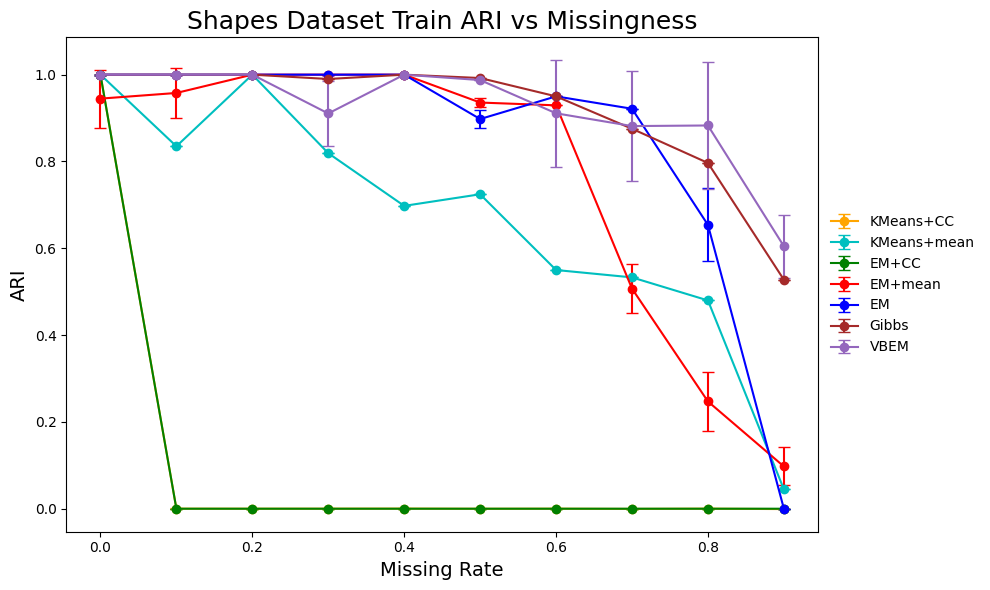

In [176]:
plot_by_missingness_line(shapes_df, metric='train_ARI', title="Shapes Dataset Train ARI vs Missingness", ylabel="ARI")

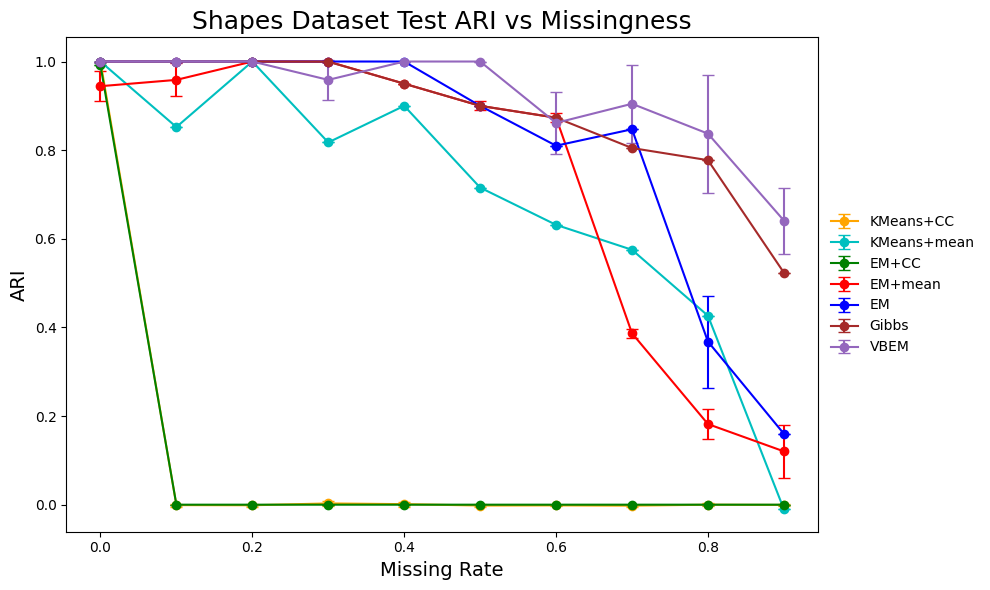

In [174]:
plot_by_missingness_line(shapes_df, metric='test_ARI', title="Shapes Dataset Test ARI vs Missingness", ylabel="ARI")

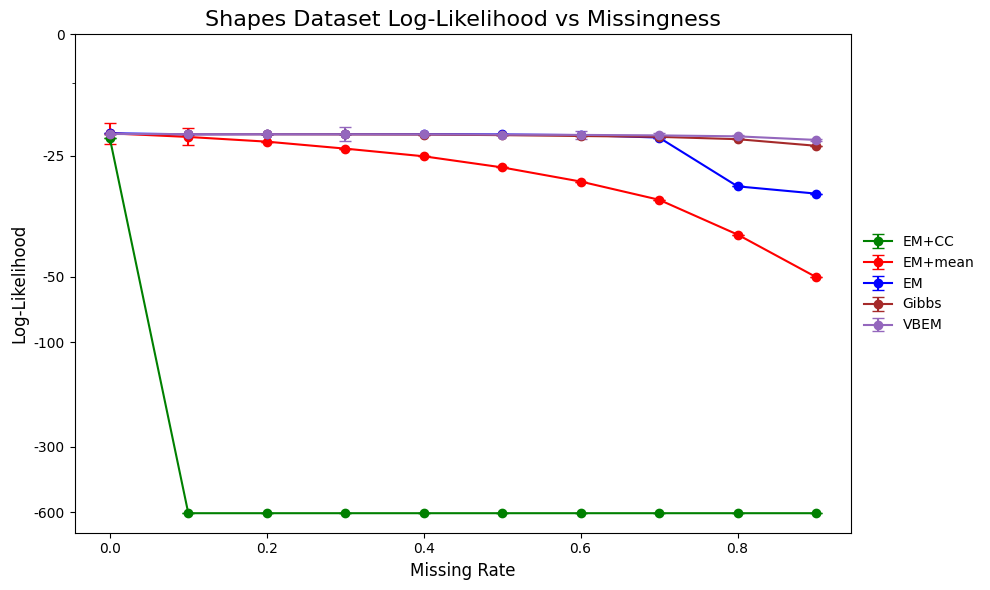

In [3811]:
plot_by_missingness_line(shapes_df, metric='loglike', 
                         title="Shapes Dataset Log-Likelihood vs Missingness", 
                         ylabel="Log-Likelihood", 
                         logscale=True,
                         ticks=[0,-25,-50,-100,-300,-600],
                         thresh=50)

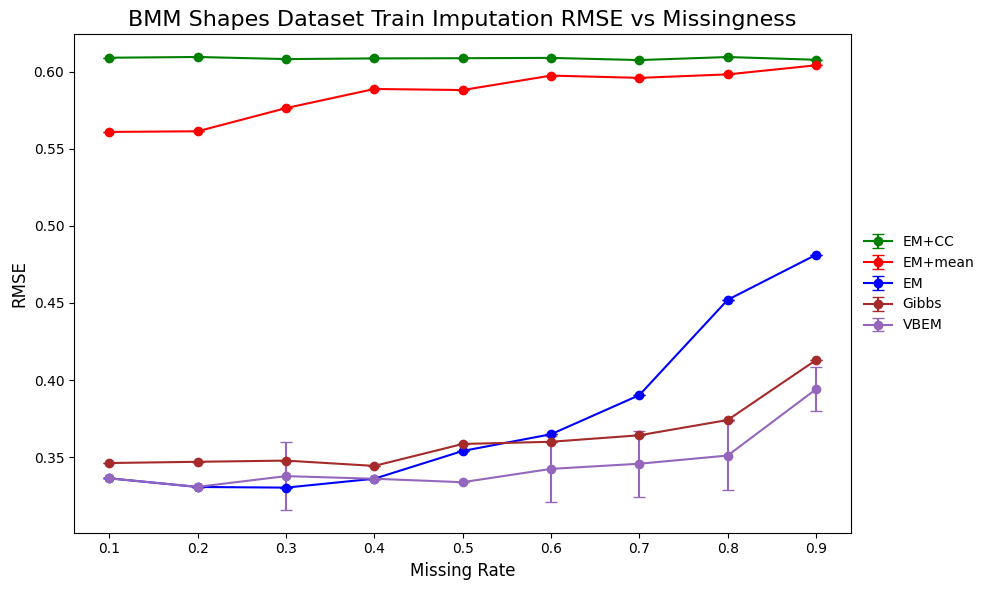

In [3812]:
plot_by_missingness_line(shapes_df, metric='RMSE_train', title="BMM Shapes Dataset Train Imputation RMSE vs Missingness", ylabel="RMSE")

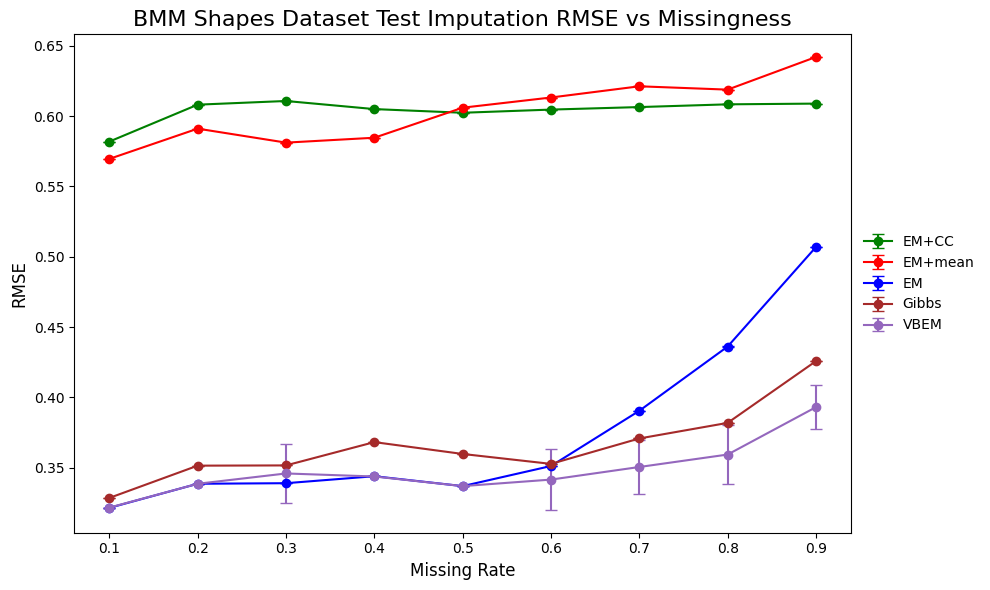

In [3814]:
plot_by_missingness_line(shapes_df, metric='RMSE_test', title="BMM Shapes Dataset Test Imputation RMSE vs Missingness", ylabel="RMSE")

## 1.2 Synthetic Good

In [2710]:
synthetic_df = pd.read_csv("./Results/bmm_synthetic.csv")

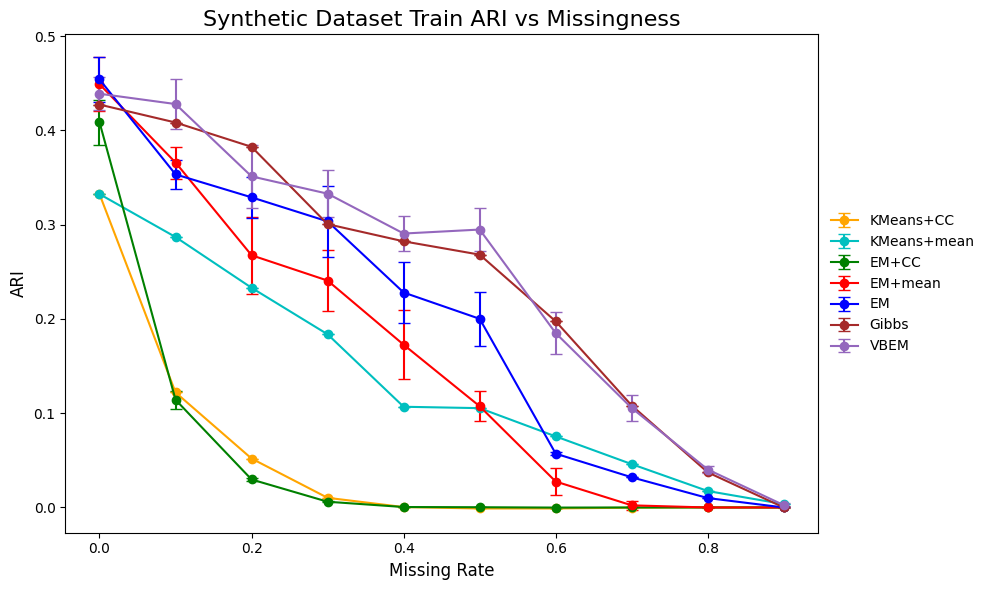

In [3166]:
plot_by_missingness_line(synthetic_df, metric='train_ARI', title="Synthetic Dataset Train ARI vs Missingness", ylabel="ARI")

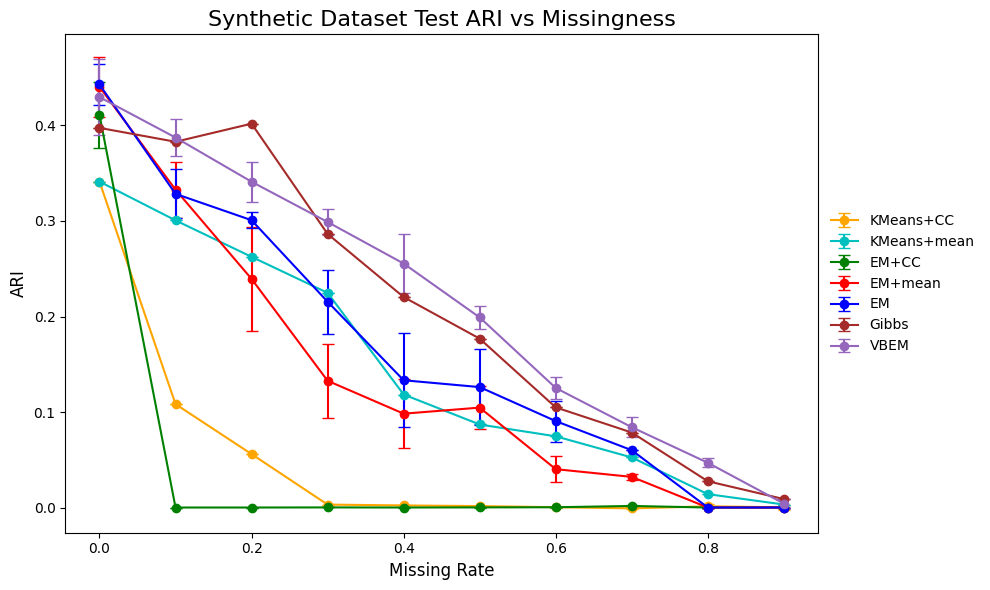

In [3165]:
plot_by_missingness_line(synthetic_df, metric='test_ARI', title="Synthetic Dataset Test ARI vs Missingness", ylabel="ARI")

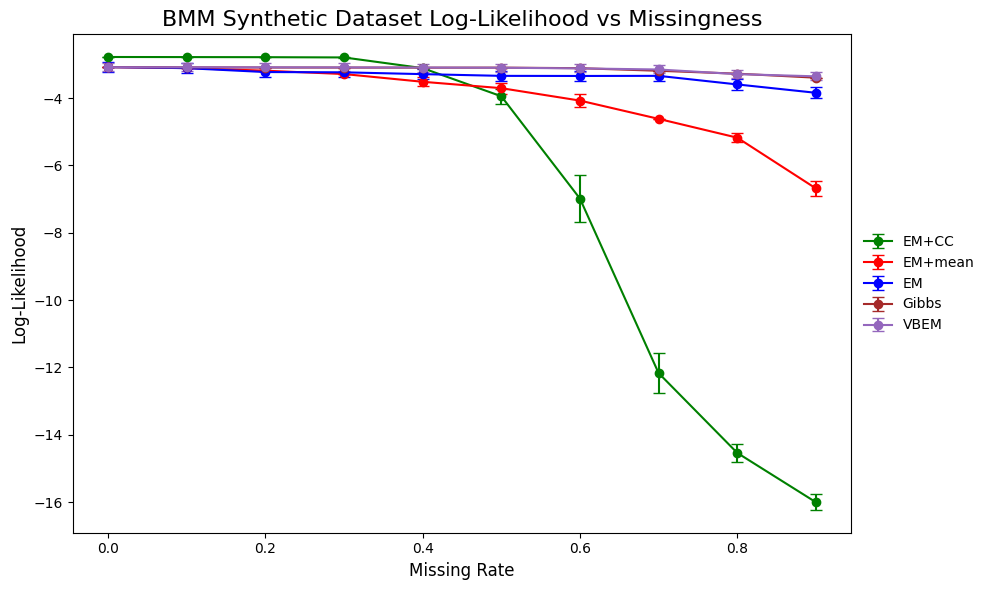

In [3164]:
plot_by_missingness_line(synthetic_df, metric='loglike', title="BMM Synthetic Dataset Log-Likelihood vs Missingness", ylabel="Log-Likelihood")

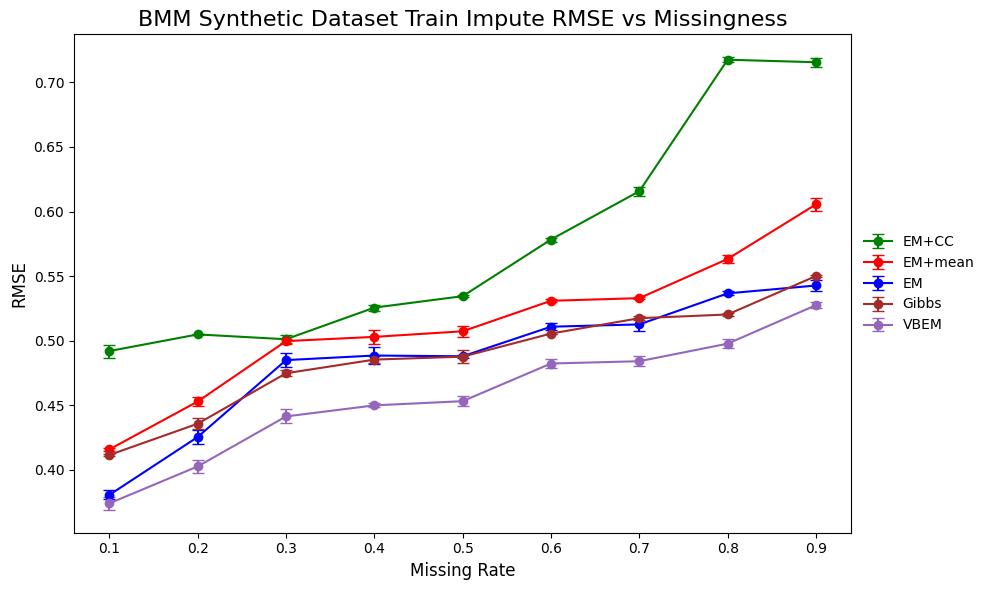

In [3641]:
plot_by_missingness_line(synthetic_df, metric='RMSE_train', title="BMM Synthetic Dataset Train Impute RMSE vs Missingness", ylabel="RMSE")

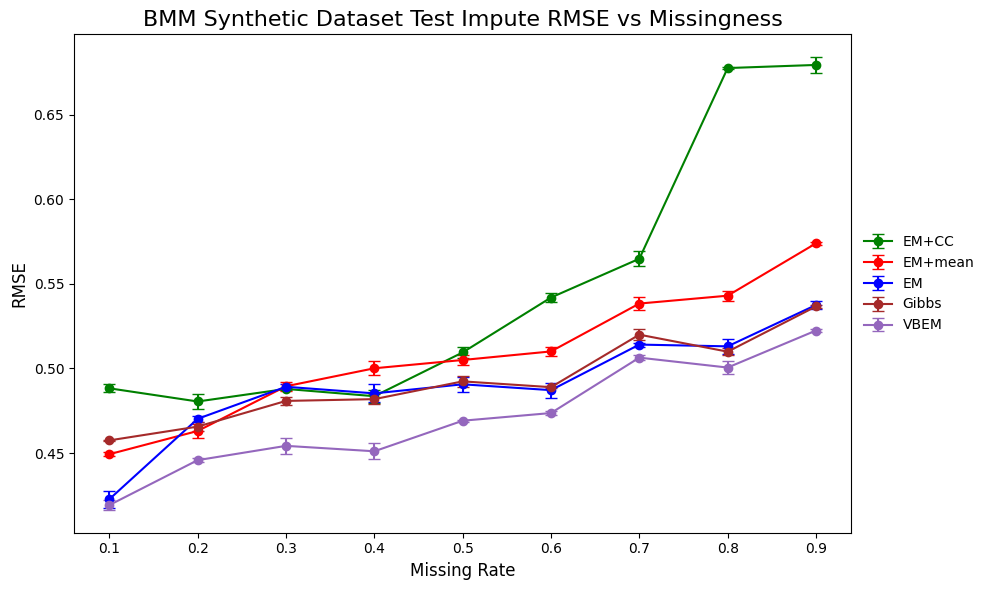

In [3643]:
plot_by_missingness_line(synthetic_df, metric='RMSE_test', title="BMM Synthetic Dataset Test Impute RMSE vs Missingness", ylabel="RMSE")

## 1.4 MP

In [2]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X_train_mp = np.load(dirpath + "X_mp2024.npy")
y_train_mp = np.load(dirpath + "y_mp2024.npy")

Gibbs

In [3]:
mp_priors = BMMPriorParameters(X_train_mp, 9)
mp_gibbs_model = BMMGibbs(mp_priors)
aligned_results = mp_gibbs_model.fit(X_train_mp)
mp_gibbs_summary = mp_gibbs_model.get_summarizing_results(y_train_mp)
mp_gibbs_mean = mp_gibbs_summary['avg_ari']
mp_gibbs_std = mp_gibbs_summary['std_ari']

In [6]:
mp_em_model = BMMEM(9)
results_em_aris = []
for i in range(10):
    result = mp_em_model.fit(X_train_mp)
    results_em_aris.append(adjusted_rand_score(result['z'], y_train_mp))
mp_em_mean = np.mean(results_em_aris)
mp_em_std = np.std(results_em_aris)

In [7]:
mp_vbem_model = BMMVBEM(mp_priors)
results_vbem_aris = []
for i in range(10):
    result = mp_vbem_model.fit(X_train_mp)
    results_vbem_aris.append(adjusted_rand_score(result['z'], y_train_mp))
mp_vbem_mean = np.mean(results_vbem_aris)
mp_vbem_std = np.std(results_vbem_aris)

In [9]:
mp_em_impute_model = BMMEM(9)
results_em_impute_aris = []
for i in range(10):
    result = mp_em_impute_model.fit(mean_impute(X_train_mp))
    results_em_impute_aris.append(adjusted_rand_score(result['z'], y_train_mp))
mp_em_impute_mean = np.mean(results_em_impute_aris)
mp_em_impute_std = np.std(results_em_impute_aris)

In [13]:
mp_cc_em_model = BMMEM(9, complete_case=True)
results_cc_em_aris = []
for i in range(10):
    result = mp_cc_em_model.fit(X_train_mp)
    results_cc_em_aris.append(adjusted_rand_score(result['z'],y_train_mp))
mp_cc_em_mean = np.mean(results_cc_em_aris)
mp_cc_em_std = np.std(results_cc_em_aris)

In [11]:
mp_kmeans_impute_model = CustomKMeans(9)
results_kmeans_impute_aris = []
for i in range(10):
    result = mp_kmeans_impute_model.fit(mean_impute(X_train_mp))
    results_kmeans_impute_aris.append(adjusted_rand_score(result['z'],y_train_mp))
mp_kmeans_impute_mean = np.mean(results_kmeans_impute_aris)
mp_kmeans_impute_std = np.std(results_kmeans_impute_aris)

In [14]:
mp_cc_kmeans_model = CustomKMeans(9, complete_case=True)
results_cc_kmeans_aris = []
for i in range(10):
    result = mp_cc_kmeans_model.fit(X_train_mp)
    results_cc_kmeans_aris.append(adjusted_rand_score(result['z'],y_train_mp))
mp_cc_kmeans_mean = np.mean(results_cc_kmeans_aris)
mp_cc_kmeans_std = np.std(results_cc_kmeans_aris)

In [15]:
mp_means = [mp_gibbs_mean, mp_vbem_mean, mp_em_mean, mp_em_impute_mean, mp_cc_em_mean, mp_kmeans_impute_mean, mp_cc_kmeans_mean]
mp_stds  = [mp_gibbs_std, mp_vbem_std, mp_em_std, mp_em_impute_std, mp_cc_em_std, mp_kmeans_impute_std, mp_cc_kmeans_std]
mp_labels = ["Gibbs", "VBEM", "EM", "EM+mean", "EM+CC", "KMeans+mean","KMeans+CC"]

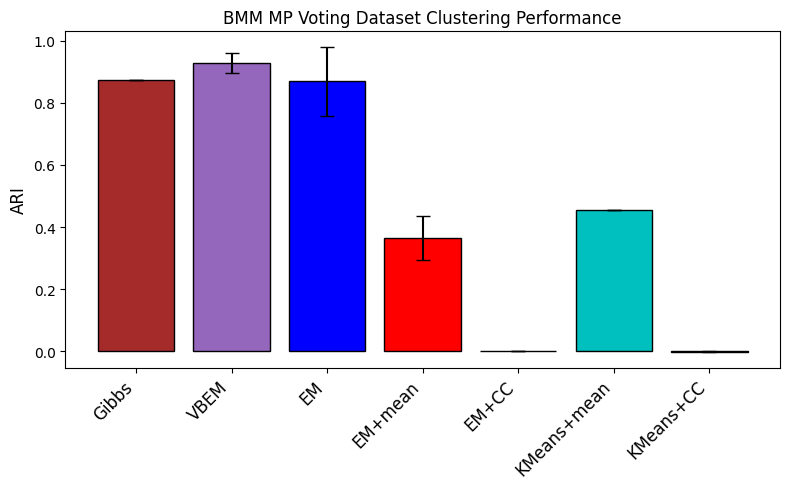

In [23]:

x = np.arange(len(mp_labels))
colors = [color_dict[label] for label in mp_labels]

plt.figure(figsize=(8, 5))
plt.bar(x, mp_means, yerr=mp_stds, capsize=5, color=colors, edgecolor='black')

plt.xticks(x, mp_labels, rotation=45, ha='right', fontsize=12)
plt.ylabel("ARI", fontsize=12)
plt.title("BMM MP Voting Dataset Clustering Performance")

plt.tight_layout()
plt.show()

---

# 2 GMM

## 2.1 Palmer Penguins GOOD

In [2410]:
penguin_df = pd.read_csv("./Results/gmm_penguin.csv")

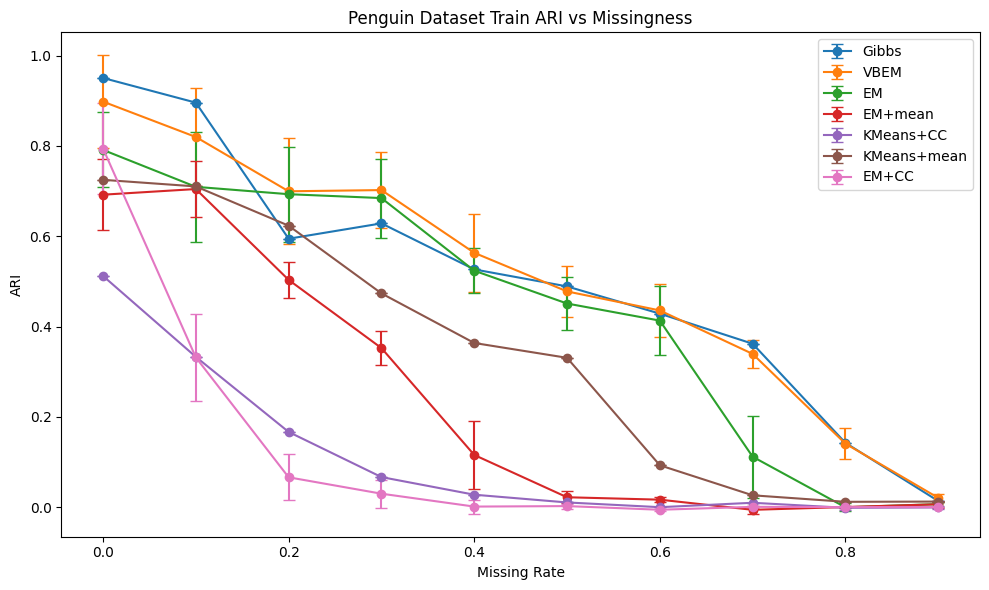

In [ ]:
plot_by_missingness_line(penguin_df, metric='train_ARI', title="Penguin Dataset Train ARI vs Missingness", ylabel="ARI")

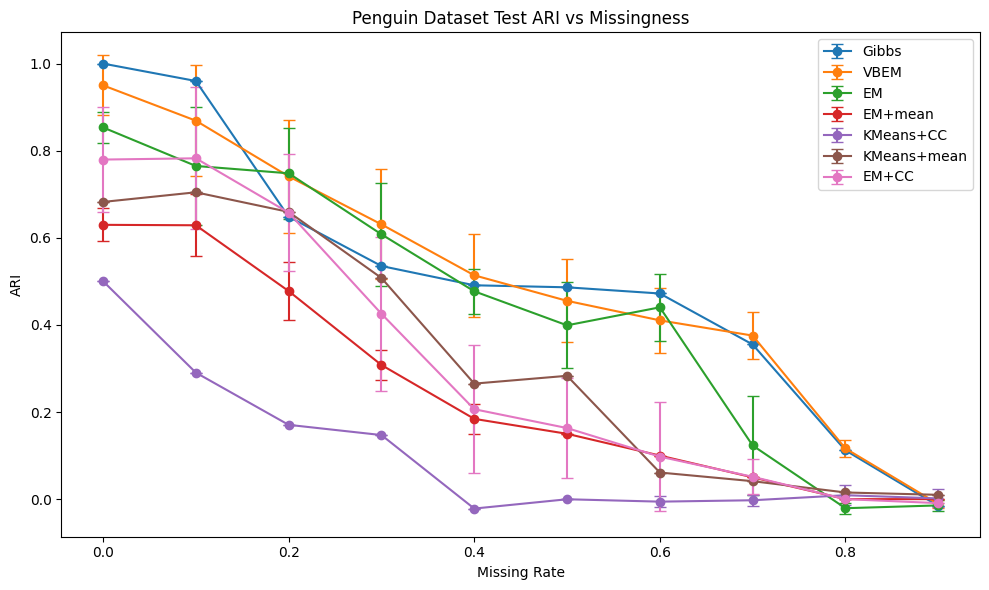

In [ ]:
plot_by_missingness_line(penguin_df, metric='test_ARI', title="Penguin Dataset Test ARI vs Missingness", ylabel="ARI")

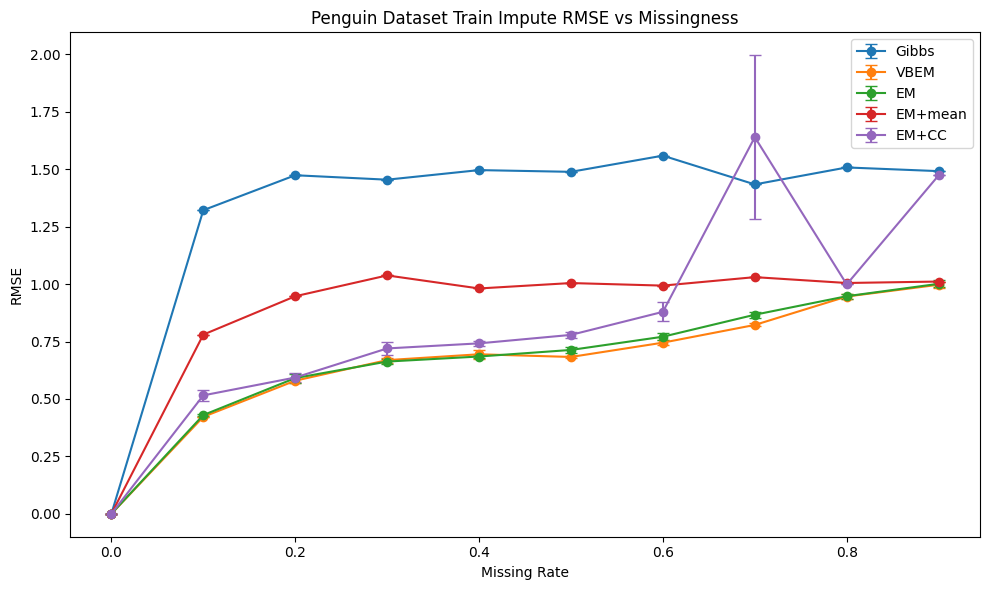

In [ ]:
plot_by_missingness_line(penguin_df, metric='RMSE_train', title="Penguin Dataset Train Impute RMSE vs Missingness", ylabel="RMSE")

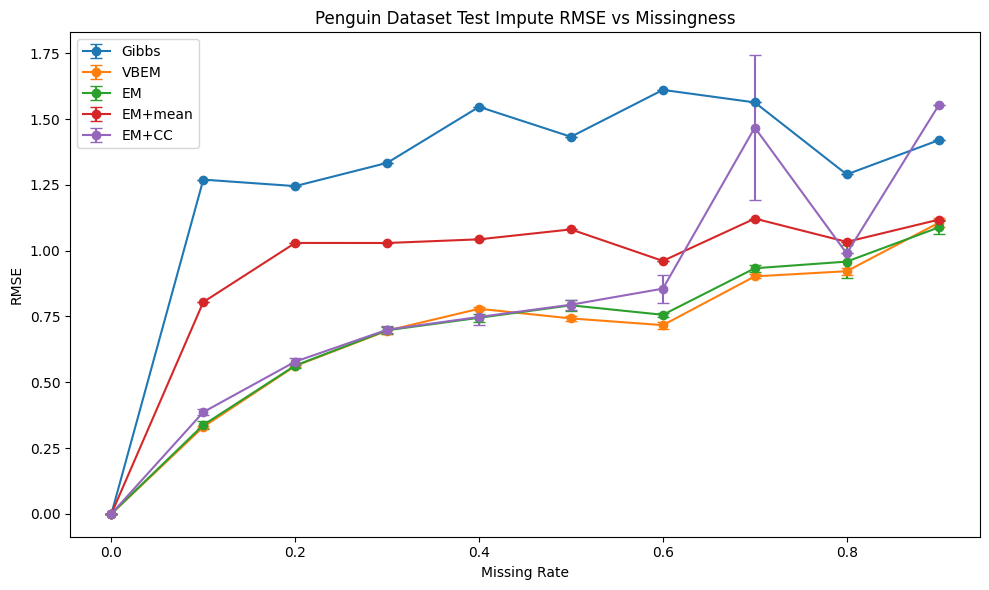

In [ ]:
plot_by_missingness_line(penguin_df, metric='RMSE_test', title="Penguin Dataset Test Impute RMSE vs Missingness", ylabel="RMSE")

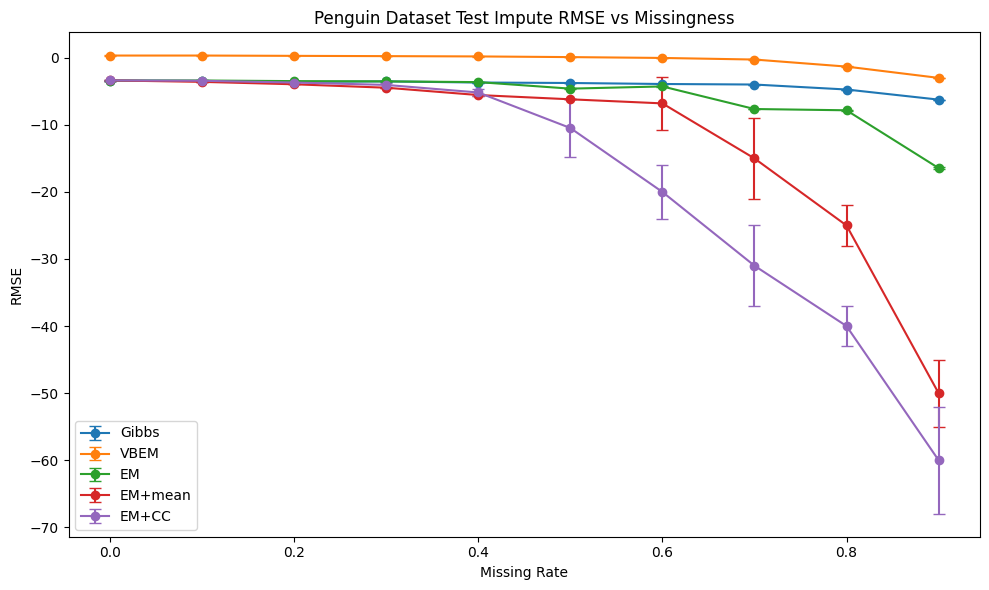

In [ ]:
plot_by_missingness_line(penguin_df, metric='loglike', title="Penguin Dataset Test Impute RMSE vs Missingness", ylabel="RMSE")

## 2.2 IRIS

In [4420]:
iris_df = pd.read_csv('./Results/gmm_iris.csv')

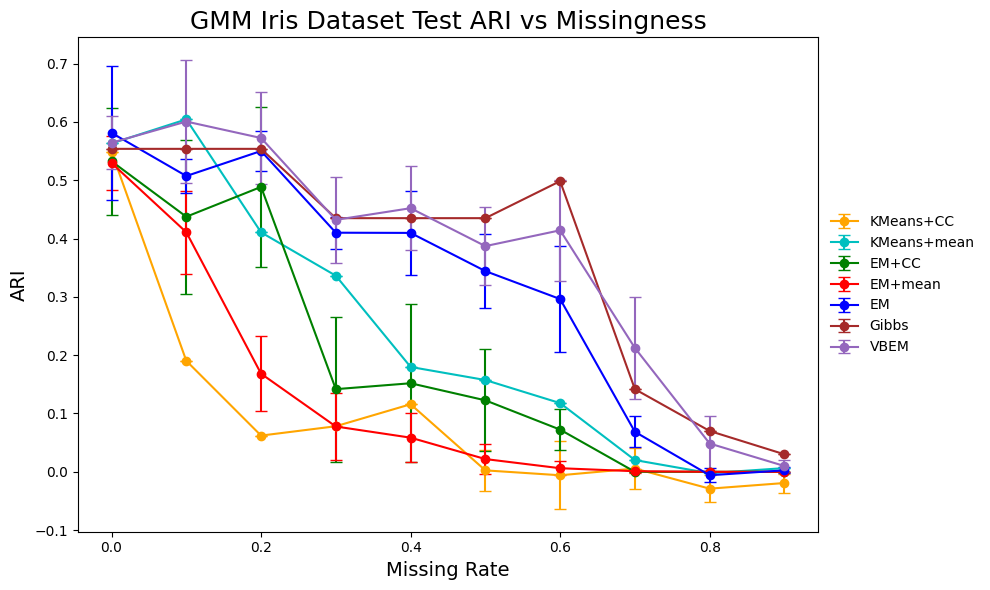

In [223]:
plot_by_missingness_line(iris_df, metric='test_ARI', title="GMM Iris Dataset Test ARI vs Missingness", ylabel="ARI")

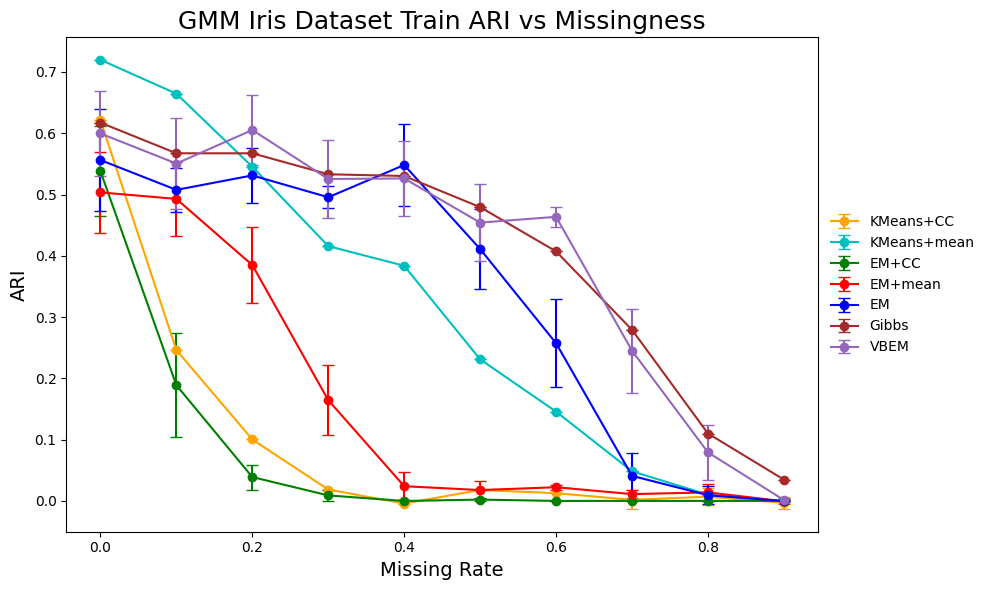

In [205]:
plot_by_missingness_line(iris_df, metric='train_ARI', title="GMM Iris Dataset Train ARI vs Missingness", ylabel="ARI")

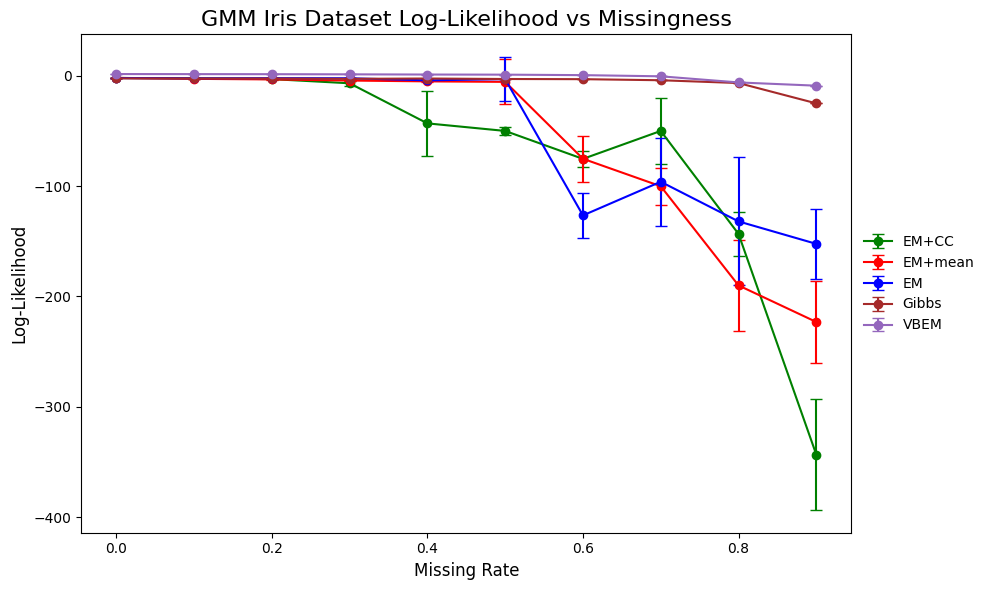

In [3640]:
plot_by_missingness_line(iris_df, metric='loglike', title="GMM Iris Dataset Log-Likelihood vs Missingness", ylabel="Log-Likelihood")

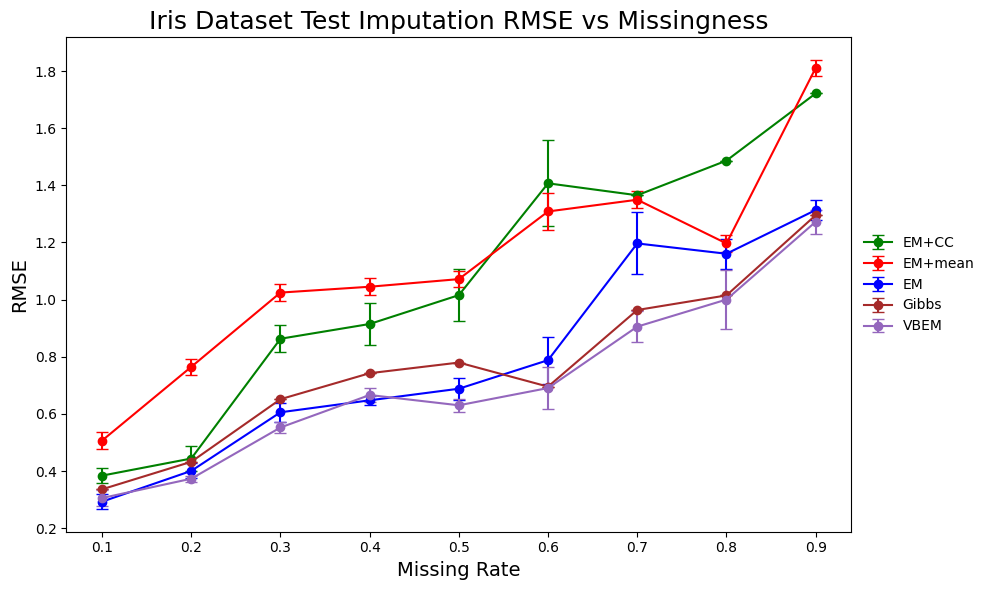

In [666]:
plot_by_missingness_line(iris_df, metric='RMSE_test', title="Iris Dataset Test Imputation RMSE vs Missingness", ylabel="RMSE")

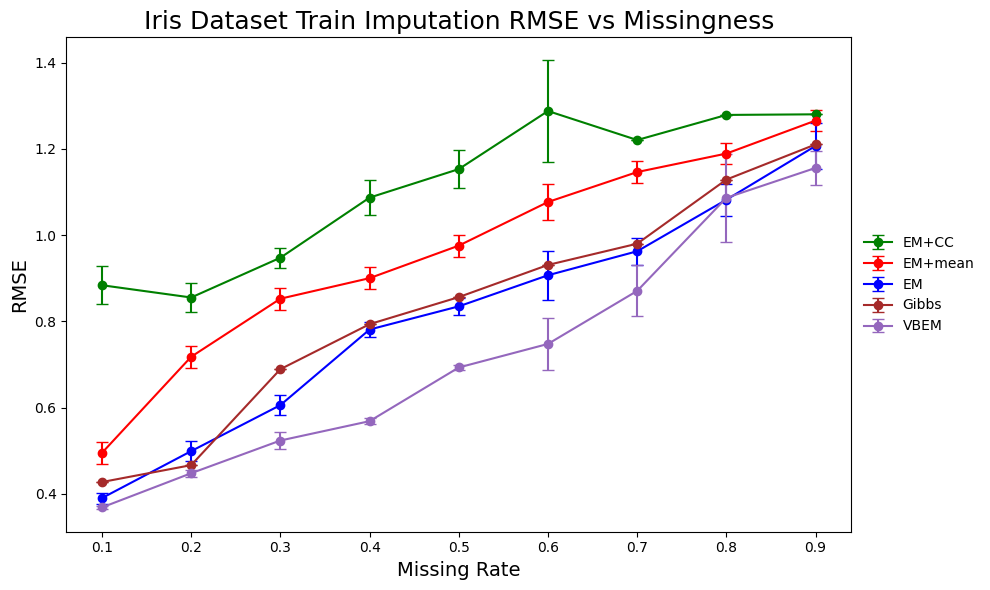

In [639]:
plot_by_missingness_line(iris_df, metric='RMSE_train', title="Iris Dataset Train Imputation RMSE vs Missingness", ylabel="RMSE")

## 2.3 Synthetic GOOD

In [54]:
gmm_synthetic_df = pd.read_csv("./Results/gmm_synthetic.csv")

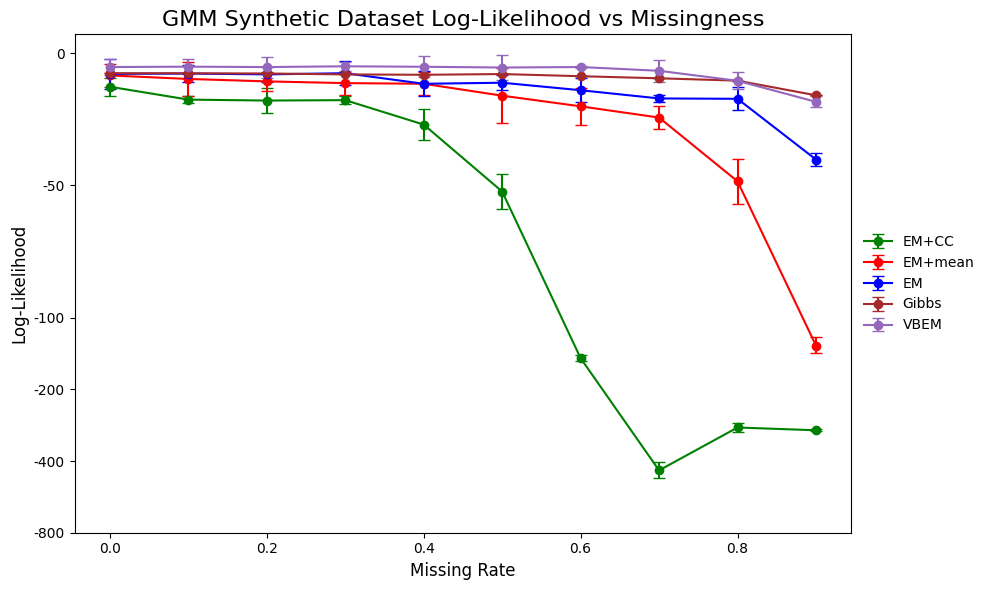

In [4759]:
plot_by_missingness_line(gmm_synthetic_df, metric='loglike', 
                         title="GMM Synthetic Dataset Log-Likelihood vs Missingness", 
                         ylabel="Log-Likelihood",
                         logscale=True,
                         ticks=[0,-50,-100,-200,-400,-800])

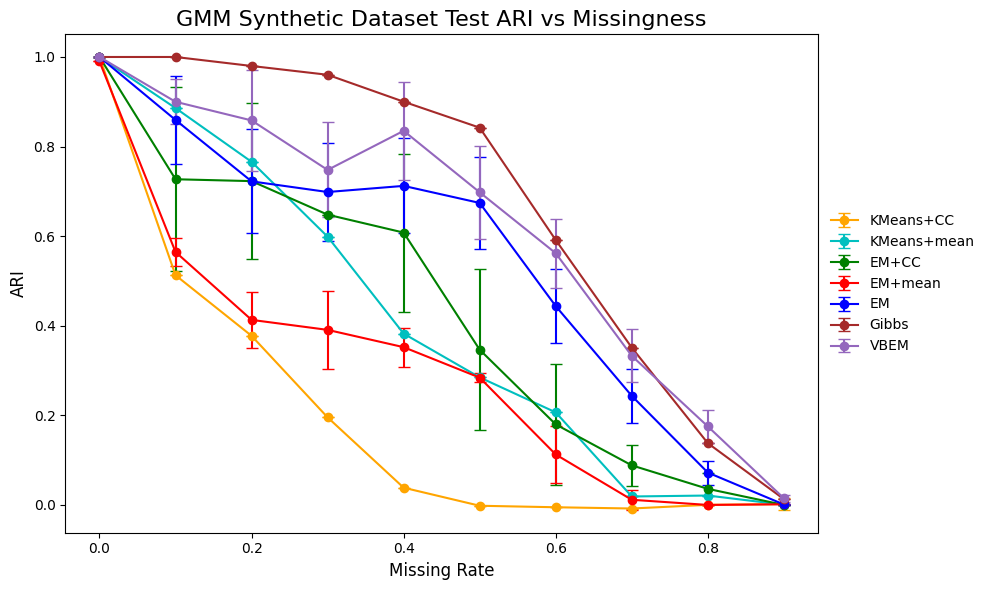

In [76]:
plot_by_missingness_line(gmm_synthetic_df, metric='test_ARI', title="GMM Synthetic Dataset Test ARI vs Missingness", ylabel="ARI")

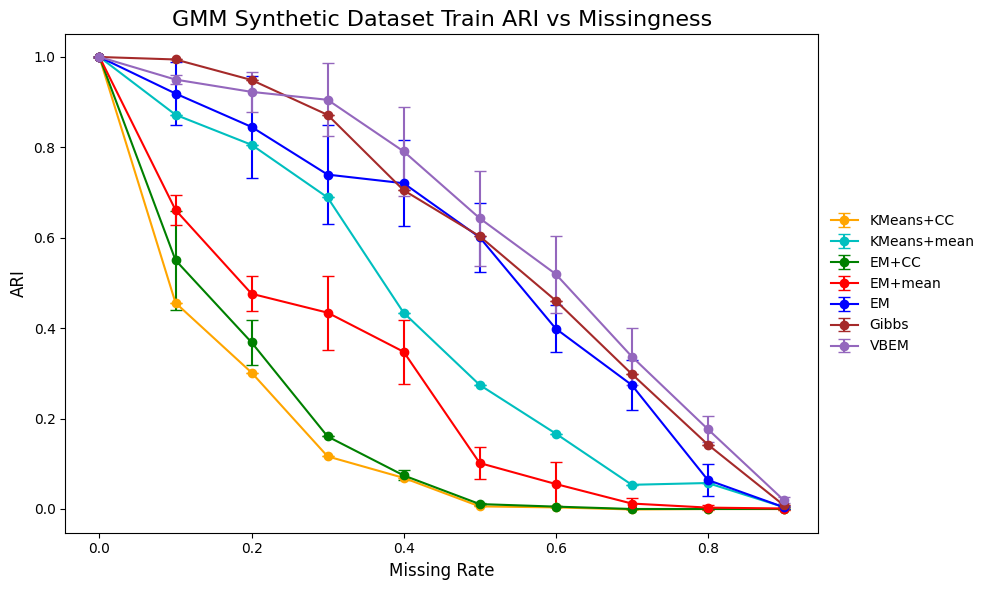

In [96]:
plot_by_missingness_line(gmm_synthetic_df, metric='train_ARI', title="GMM Synthetic Dataset Train ARI vs Missingness", ylabel="ARI")

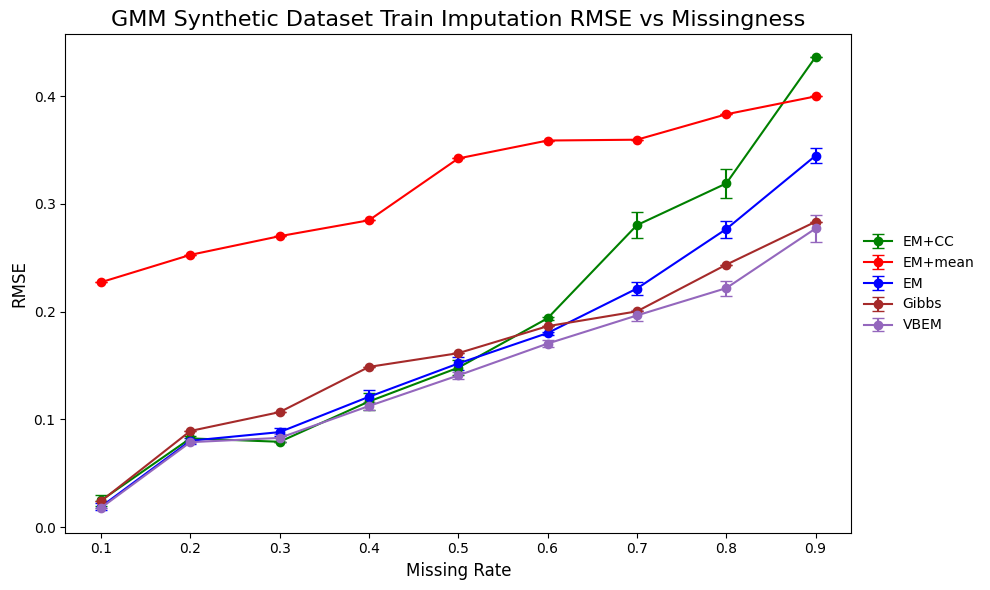

In [3926]:
plot_by_missingness_line(gmm_synthetic_df, metric='RMSE_train', title="GMM Synthetic Dataset Train Imputation RMSE vs Missingness", ylabel="RMSE")

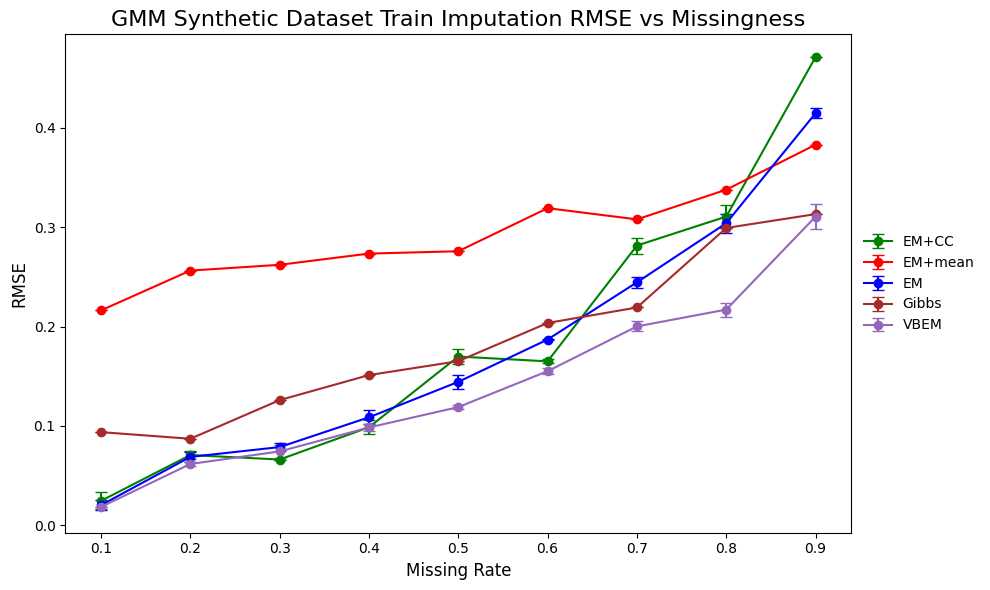

In [3994]:
plot_by_missingness_line(gmm_synthetic_df, metric='RMSE_test', title="GMM Synthetic Dataset Train Imputation RMSE vs Missingness", ylabel="RMSE")

## 2.4 Synthetic Digits

In [238]:
digits_df = pd.read_csv("./Results/gmm_digits5x5.csv")

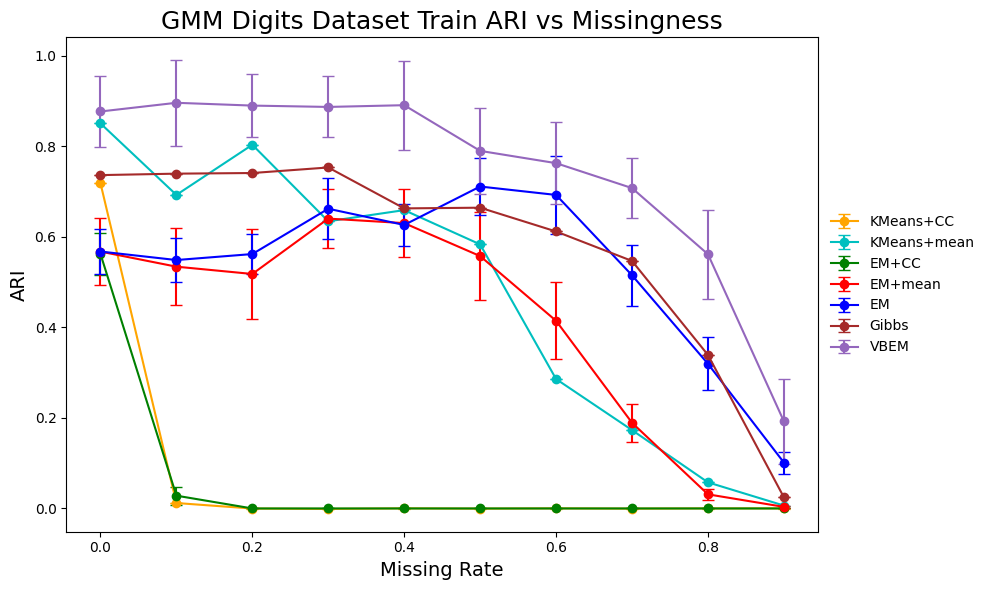

In [143]:
plot_by_missingness_line(digits_df, metric='train_ARI', title="GMM Digits Dataset Train ARI vs Missingness", ylabel="ARI")

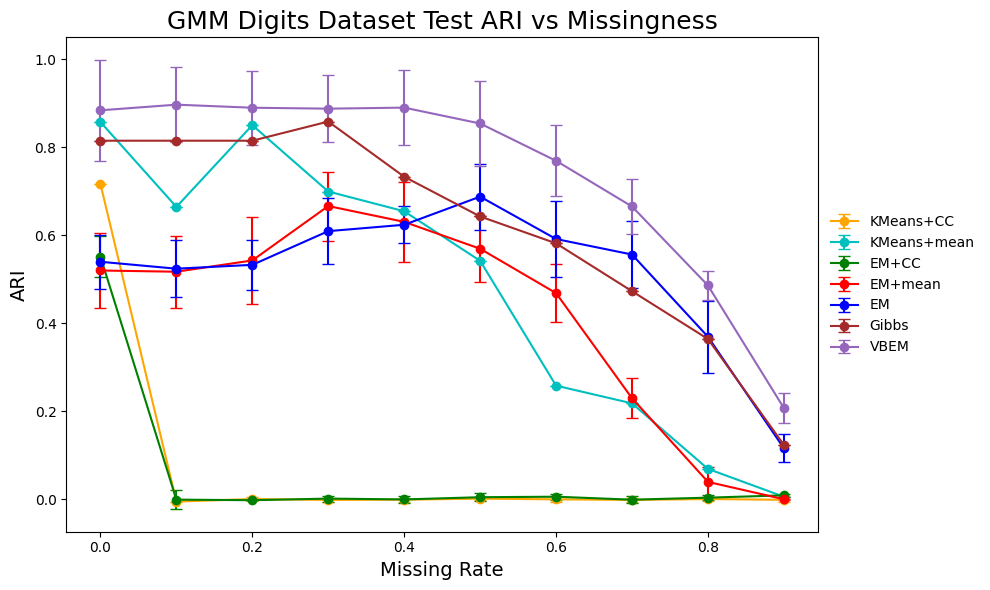

In [144]:
plot_by_missingness_line(digits_df, metric='test_ARI', title="GMM Digits Dataset Test ARI vs Missingness", ylabel="ARI")

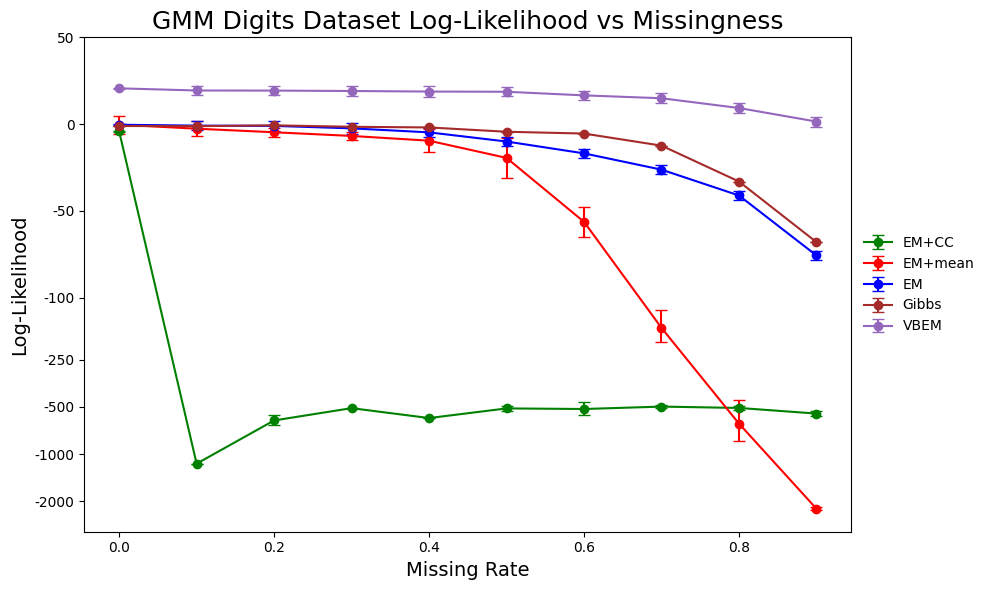

In [519]:
plot_by_missingness_line(digits_df, 
                         metric='loglike', 
                         title="GMM Digits Dataset Log-Likelihood vs Missingness", 
                         ylabel="Log-Likelihood",
                         logscale=True,
                         ticks=[50, 0,-50,-100,-250,-500,-1000, -2000])

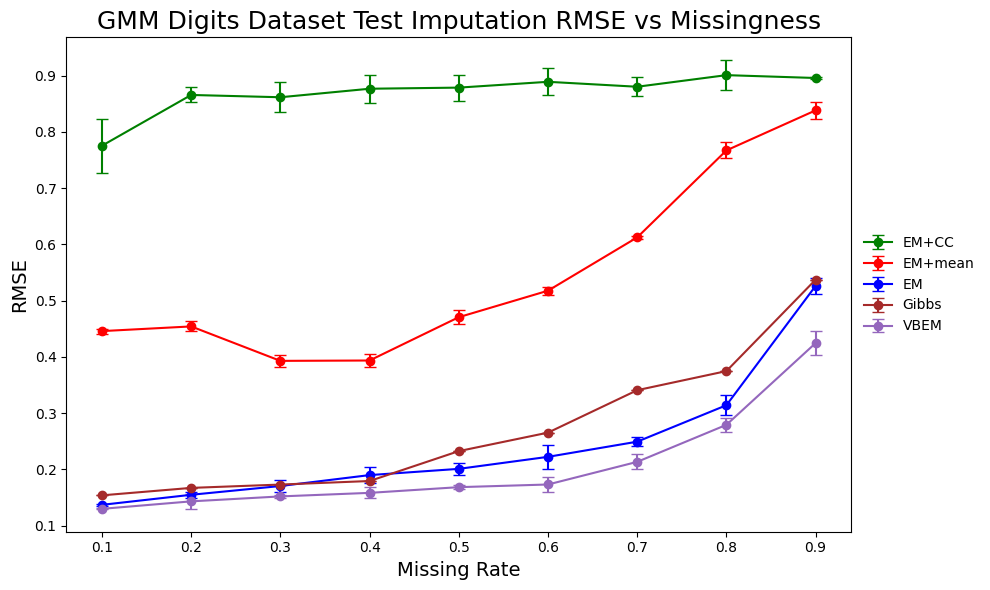

In [689]:
plot_by_missingness_line(digits_df, metric='RMSE_test', title="GMM Digits Dataset Test Imputation RMSE vs Missingness", ylabel="RMSE")

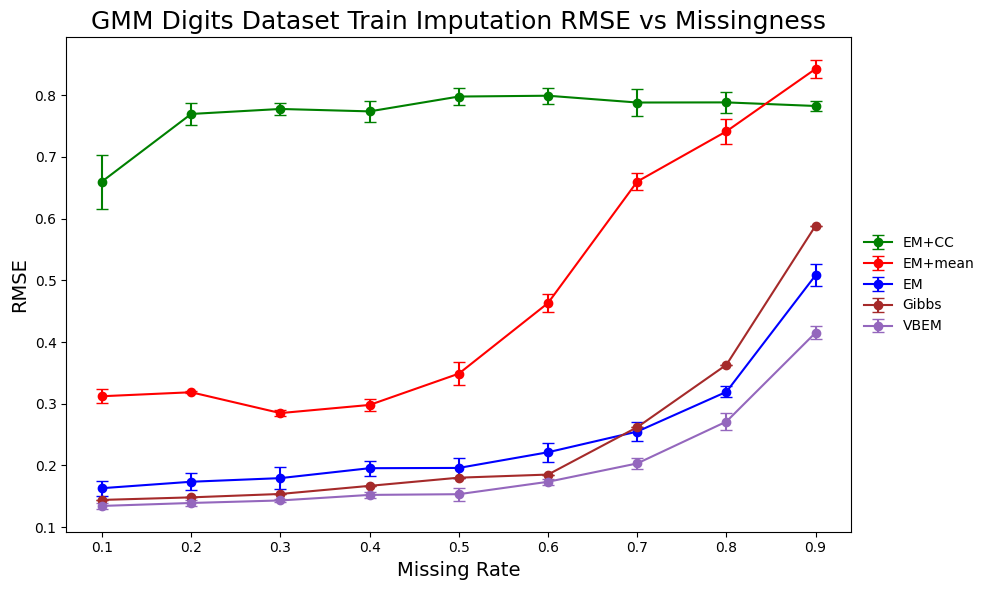

In [697]:
plot_by_missingness_line(digits_df, metric='RMSE_train', title="GMM Digits Dataset Train Imputation RMSE vs Missingness", ylabel="RMSE")

# MNAR Evaluation

## BMM

### Synthetic MNAR Dataset 
Different uniform missingness for each component

In [1470]:
def gibbs_traceplot(results_mnar, results_mcar, y):
    scores_mnar = []
    scores_mcar = []

    for i in range(len(results_mcar)):
        if i % 2 == 0 : continue
        result_mnar = results_mnar[i]
        result_mcar = results_mcar[i]
        scores_mnar.append(adjusted_rand_score(result_mnar['z'], y))
        scores_mcar.append(adjusted_rand_score(result_mcar['z'], y))

    plt.plot(scores_mnar, label="MNAR Gibbs")
    plt.plot(scores_mcar, label="MCAR Gibs")
    plt.show()

In [ ]:
def generate_mnar_mixture_data(X, y, K, max_missingness=0.9):
    N,D = X.shape

    rng = np.random.default_rng(5099)
    
    N, D = X.shape

    γ_levels = np.linspace(0.0, max_missingness, K)
    γ = np.tile(γ_levels[:, None], (1, D)) 

    R = np.ones((N, D), dtype=bool)

    for n in range(N):
        k = y[n]
        R[n] = rng.binomial(1, 1 - γ[k])

    X_missing = X.copy().astype(np.float64)
    X_missing[~R] = np.nan

    return X_missing, R


In [809]:
def generate_mnar_vec_mixture_data(X, y):
    N,D = X.shape

    templates = np.array(
        [
            [0.9,0.9,0.01,0.01,0.01],
            [0.01,0.01,0.9,0.01,0.01],
            [0.01,0.01,0.01,0.9,0.9],
        ]
    )

    if D == 3:
        templates = np.array(
            [
                [0.95,0.05,0.05],
                [0.05,0.95,0.05],
                [0.05,0.05,0.95],
            ]
        )

    rng = np.random.default_rng(5099)
    
    N, D = X.shape


    R = np.ones((N, D), dtype=bool)

    for n in range(N):
        k = y[n]
        R[n] = rng.binomial(1,1-templates[k])

    X_missing = X.copy().astype(np.float64)
    X_missing[~R] = np.nan

    return X_missing, R

In [779]:
def get_missingness(X):
    N,D = X.shape 

    return np.sum(np.any(np.isnan(X))) 

In [772]:
dirpath_synthetic = "./../Datasets/Bernoulli/Processed/synthetic_3x5/"

X_train_bmm_synthetic = np.load(dirpath_synthetic + "X_train_synthetic_3x5.npy")
y_train_bmm_synthetic = np.load(dirpath_synthetic + "y_train_synthetic_3x5.npy")
X_test_bmm_synthetic = np.load(dirpath_synthetic + "X_test_synthetic_3x5.npy")
y_test_bmm_synthetic = np.load(dirpath_synthetic + "y_test_synthetic_3x5.npy")
means = np.load(dirpath_synthetic + "means_synthetic_3x5.npy")


#### Missing Vector

In [790]:

X_train_mnar_bmm1 = generate_mnar_vec_mixture_data(X_train_bmm_synthetic, y_train_bmm_synthetic)[0]
X_test_mnar_bmm1 = generate_mnar_vec_mixture_data(X_test_bmm_synthetic, y_test_bmm_synthetic)[0]

In [791]:
bmm_mnar_params1 = BMMPriorParameters(X_train_mnar_bmm1, 3)
bmm_gibbs_mnar1 = BMMGibbs(bmm_mnar_params1)
bmm_gibbs_mcar1 = BMMGibbs(bmm_mnar_params1)
bmm_result_mnar1 = bmm_gibbs_mnar1.fit(X_train_mnar_bmm1, mnar=True)
bmm_result_mcar1 = bmm_gibbs_mcar1.fit(X_train_mnar_bmm1, mnar=False)

In [792]:
bmm_mnar_ari1 = adjusted_rand_score(bmm_result_mnar1['z'], y_train_bmm_synthetic)
bmm_mcar_ari1 = adjusted_rand_score(bmm_result_mcar1['z'], y_train_bmm_synthetic)
print(bmm_mnar_ari1, bmm_mcar_ari1)
print(bmm_gibbs_mnar1.get_summarizing_results(y_train_bmm_synthetic))
print(bmm_gibbs_mcar1.get_summarizing_results(y_train_bmm_synthetic))

0.388371083133406 0.355230795736025
{'avg_ari': np.float64(0.19937619385138802), 'std_ari': np.float64(0.049938784700115035), 'avg_ll': np.float64(-3.0573764579029), 'std_ll': np.float64(0.022468439717883495), 'avg_pl': np.float64(-6553.8658339548065), 'std_pl': np.float64(106.6987750677366)}
{'avg_ari': np.float64(0.16662672875261442), 'std_ari': np.float64(0.020735146771644584), 'avg_ll': np.float64(-3.0514698444557404), 'std_ll': np.float64(0.022657131820864408), 'avg_pl': np.float64(-6542.5967694736355), 'std_pl': np.float64(125.64093688975409)}


In [794]:
bmm_result_mnar_test_predict1 = bmm_gibbs_mnar1.predict(X_test_mnar_bmm1, mnar=True)
bmm_result_mcar_test_predict1 = bmm_gibbs_mcar1.predict(X_test_mnar_bmm1, mnar=False)
print(adjusted_rand_score(bmm_result_mnar_test_predict1, y_test_bmm_synthetic), adjusted_rand_score(bmm_result_mcar_test_predict1, y_test_bmm_synthetic))

0.41256541347114056 0.3922906312665578


#### Uniform Missing

In [802]:

X_train_mnar_bmm = generate_mnar_mixture_data(X_train_bmm_synthetic, y_train_bmm_synthetic, 3)[0]
X_test_mnar_bmm = generate_mnar_mixture_data(X_test_bmm_synthetic, y_test_bmm_synthetic, 3)[0]

mnar_dataset_train_bmm = Dataset(X_train_mnar_bmm, y_train_bmm_synthetic)
mnar_dataset_test_bmm = Dataset(X_test_mnar_bmm, y_test_bmm_synthetic)

[[0.   0.   0.   0.   0.  ]
 [0.45 0.45 0.45 0.45 0.45]
 [0.9  0.9  0.9  0.9  0.9 ]]
[[0.   0.   0.   0.   0.  ]
 [0.45 0.45 0.45 0.45 0.45]
 [0.9  0.9  0.9  0.9  0.9 ]]


Instantiate Models

In [805]:
bmm_mnar_params = BMMPriorParameters(X_train_mnar_bmm, 3)
bmm_gibbs_mnar = BMMGibbs(bmm_mnar_params)
bmm_gibbs_mcar = BMMGibbs(bmm_mnar_params)

In [748]:
bmm_result_mnar = bmm_gibbs_mnar.fit(X_train_mnar_bmm, mnar=True)
bmm_result_mcar = bmm_gibbs_mcar.fit(X_train_mnar_bmm, mnar=False)

In [749]:
bmm_mnar_ari = adjusted_rand_score(bmm_result_mnar['z'], y_train_bmm_synthetic)
bmm_mcar_ari = adjusted_rand_score(bmm_result_mcar['z'], y_train_bmm_synthetic)

In [750]:
print(bmm_mnar_ari, bmm_mcar_ari)

0.19889540676516168 0.197253654776025


In [796]:
print(bmm_gibbs_mnar.get_summarizing_results(y_train_bmm_synthetic))
print(bmm_gibbs_mcar.get_summarizing_results(y_train_bmm_synthetic))

{'avg_ari': np.float64(0.08657918843484727), 'std_ari': np.float64(0.016277026934942523), 'avg_ll': np.float64(-2.8647958763811605), 'std_ll': np.float64(0.020586088317711915), 'avg_pl': np.float64(-6538.639413537548), 'std_pl': np.float64(265.31600858401845)}
{'avg_ari': np.float64(0.08262737352470147), 'std_ari': np.float64(0.014940337384228704), 'avg_ll': np.float64(-2.8653634919433495), 'std_ll': np.float64(0.020085610254254996), 'avg_pl': np.float64(-6509.591309879615), 'std_pl': np.float64(250.88797281683722)}


In [752]:
bmm_result_mnar_test_predict = bmm_gibbs_mnar.predict(X_test_mnar_bmm, mnar=True)
bmm_result_mcar_test_predict = bmm_gibbs_mcar.predict(X_test_mnar_bmm, mnar=False)
print(adjusted_rand_score(bmm_result_mnar_test_predict, y_test_bmm_synthetic), adjusted_rand_score(bmm_result_mcar_test_predict, y_test_bmm_synthetic))

0.32529157294559785 0.20090469632096686


### MP

In [162]:
mp_params = BMMPriorParameters(X_train_mp, 9)
mp_gibbs_mnar = BMMGibbs(mp_params)
mp_gibbs_mcar = BMMGibbs(mp_params)

In [163]:
mp_result_mnar = mp_gibbs_mnar.fit(X_train_mp, mnar=True)
mp_result_mcar = mp_gibbs_mcar.fit(X_train_mp, mnar=False)

In [699]:
print(adjusted_rand_score(y_train_mp, mp_result_mnar['z']))
print(adjusted_rand_score(y_train_mp, mp_result_mcar['z']))

0.8622658107790799
0.7974799686049607


In [795]:
print(mp_gibbs_mnar.get_summarizing_results(y_train_mp))
print(mp_gibbs_mcar.get_summarizing_results(y_train_mp))

{'avg_ari': np.float64(0.8616827901029723), 'std_ari': np.float64(0.001330510714295049), 'avg_ll': np.float64(-21.045745999566112), 'std_ll': np.float64(0.42551815337308835), 'avg_pl': np.float64(-13564.893739409232), 'std_pl': np.float64(274.9949366855568)}
{'avg_ari': np.float64(0.7974694415423041), 'std_ari': np.float64(2.285751234588749e-05), 'avg_ll': np.float64(-20.421006760156846), 'std_ll': np.float64(0.3165830428957758), 'avg_pl': np.float64(-13150.60065016486), 'std_pl': np.float64(204.2888976688132)}


## GMM

In [714]:
dirpath_synthetic = "./../Datasets/Gaussian/Processed/synthetic/"

X_train_gmm_synthetic = np.load(dirpath_synthetic + "X_train_synthetic.npy")
y_train_gmm_synthetic = np.load(dirpath_synthetic + "y_train_synthetic.npy")
X_test_gmm_synthetic = np.load(dirpath_synthetic + "X_test_synthetic.npy")
y_test_gmm_synthetic = np.load(dirpath_synthetic + "y_test_synthetic.npy")
means = np.load(dirpath_synthetic + "means_synthetic.npy")

X_train_mnar_gmm = generate_mnar_mixture_data(X_train_gmm_synthetic, y_train_gmm_synthetic, 3)[0]
X_test_mnar_gmm = generate_mnar_mixture_data(X_test_gmm_synthetic, y_test_gmm_synthetic, 3)[0]

mnar_dataset_train_gmm = Dataset(X_train_mnar_gmm, y_train_gmm_synthetic)
mnar_dataset_test_bmm = Dataset(X_test_mnar_gmm, y_test_gmm_synthetic)

#### Uniform MNAR

In [715]:
gmm_mnar_params = GMMPriorParameters(X_train_mnar_gmm, 3)
gmm_gibbs_mnar = GMMGibbs(gmm_mnar_params)
gmm_gibbs_mcar = GMMGibbs(gmm_mnar_params)

In [716]:
gmm_result_mnar = gmm_gibbs_mnar.fit(X_train_mnar_gmm, mnar=True)
gmm_result_mcar = gmm_gibbs_mcar.fit(X_train_mnar_gmm, mnar=False)

In [717]:
gmm_mnar_ari = adjusted_rand_score(gmm_result_mnar['z'], y_train_gmm_synthetic)
gmm_mcar_ari = adjusted_rand_score(gmm_result_mcar['z'], y_train_gmm_synthetic)
print(gmm_mnar_ari, gmm_mcar_ari)
print(gmm_gibbs_mnar.get_summarizing_results(y_train_gmm_synthetic))
print(gmm_gibbs_mcar.get_summarizing_results(y_train_gmm_synthetic))

0.7661439374620591 0.44907808860134396
{'avg_ari': np.float64(0.7661439374620591), 'std_ari': np.float64(0.0), 'avg_ll': np.float64(-8.719024292425646), 'std_ll': np.float64(0.13207249922467668), 'avg_pl': np.float64(-4718.525368780457), 'std_pl': np.float64(80.64981569696639)}
{'avg_ari': np.float64(0.44907808860134407), 'std_ari': np.float64(1.1102230246251565e-16), 'avg_ll': np.float64(-7.996988557676732), 'std_ll': np.float64(0.07064592350283375), 'avg_pl': np.float64(-4938.239752973291), 'std_pl': np.float64(44.086196014422704)}


In [719]:
gmm_result_mnar_test_predict = gmm_gibbs_mnar.predict(X_test_mnar_gmm)
gmm_result_mcar_test_predict = gmm_gibbs_mcar.predict(X_test_mnar_gmm)
print(adjusted_rand_score(gmm_result_mnar_test_predict, y_test_gmm_synthetic), adjusted_rand_score(gmm_result_mcar_test_predict, y_test_gmm_synthetic))

0.9216176428609295 0.4959374150481771


#### Pattern MNAR

In [813]:
import models.GMMGibbs
importlib.reload(models.GMMGibbs)


<module 'models.GMMGibbs' from '/cs/home/jz75/Documents/2024-2025/CS5099/CS5099-Practice/models/GMMGibbs.py'>

In [814]:
dirpath_synthetic = "./../Datasets/Gaussian/Processed/synthetic/"

X_train_gmm_synthetic = np.load(dirpath_synthetic + "X_train_synthetic.npy")
y_train_gmm_synthetic = np.load(dirpath_synthetic + "y_train_synthetic.npy")
X_test_gmm_synthetic = np.load(dirpath_synthetic + "X_test_synthetic.npy")
y_test_gmm_synthetic = np.load(dirpath_synthetic + "y_test_synthetic.npy")
means = np.load(dirpath_synthetic + "means_synthetic.npy")

X_train_mnar_gmm1 = generate_mnar_vec_mixture_data(X_train_gmm_synthetic, y_train_gmm_synthetic)[0]
X_test_mnar_gmm1 = generate_mnar_vec_mixture_data(X_test_gmm_synthetic, y_test_gmm_synthetic)[0]

In [815]:
gmm_mnar_params1 = GMMPriorParameters(X_train_mnar_gmm1, 3)
gmm_gibbs_mnar1 = GMMGibbs(gmm_mnar_params1)
gmm_gibbs_mcar1 = GMMGibbs(gmm_mnar_params1)

In [817]:
gmm_result_mnar1 = gmm_gibbs_mnar1.fit(X_train_mnar_gmm1, mnar=True)
gmm_result_mcar1 = gmm_gibbs_mcar1.fit(X_train_mnar_gmm1, mnar=False)
gmm_mnar_ari1 = adjusted_rand_score(gmm_result_mnar1['z'], y_train_gmm_synthetic)
gmm_mcar_ari1 = adjusted_rand_score(gmm_result_mcar1['z'], y_train_gmm_synthetic)
print(gmm_mnar_ari1, gmm_mcar_ari1)
print(gmm_gibbs_mnar1.get_summarizing_results(y_train_gmm_synthetic))
print(gmm_gibbs_mcar1.get_summarizing_results(y_train_gmm_synthetic))

0.9651855103130051 0.4627596400720868
{'avg_ari': np.float64(0.9651855103130055), 'std_ari': np.float64(3.3306690738754696e-16), 'avg_ll': np.float64(-8.49926137615872), 'std_ll': np.float64(0.1279359609014177), 'avg_pl': np.float64(-4811.026333639703), 'std_pl': np.float64(79.35486681035881)}
{'avg_ari': np.float64(0.4514357154713699), 'std_ari': np.float64(0.010888504937587841), 'avg_ll': np.float64(-9.533128194920707), 'std_ll': np.float64(0.1115387265306905), 'avg_pl': np.float64(-5886.036577047291), 'std_pl': np.float64(72.90591630682108)}


In [819]:
gmm_result_mnar_test_predict1 = gmm_gibbs_mnar1.predict(X_test_mnar_gmm1)
gmm_result_mcar_test_predict1 = gmm_gibbs_mcar1.predict(X_test_mnar_gmm1)
print(adjusted_rand_score(gmm_result_mnar_test_predict1, y_test_gmm_synthetic), adjusted_rand_score(gmm_result_mcar_test_predict1, y_test_gmm_synthetic))

1.0 0.5489713200964548


## 1.4 MP

In [ ]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X_train_mp = np.load(dirpath + "X_mp2024.npy")
y_train_mp = np.load(dirpath + "y_mp2024.npy")

Gibbs

In [ ]:
mp_priors = BMMPriorParameters(X_train_mp, 9)
mp_gibbs_model = BMMGibbs(mp_priors)
aligned_results = mp_gibbs_model.fit(X_train_mp)
mp_gibbs_summary = mp_gibbs_model.get_summarizing_results(y_train_mp)
mp_gibbs_mean = mp_gibbs_summary['avg_ari']
mp_gibbs_std = mp_gibbs_summary['std_ari']

In [ ]:
mp_means = [mp_gibbs_mean, mp_vbem_mean, mp_em_mean, mp_em_impute_mean, mp_cc_em_mean, mp_kmeans_impute_mean, mp_cc_kmeans_mean]
mp_stds  = [mp_gibbs_std, mp_vbem_std, mp_em_std, mp_em_impute_std, mp_cc_em_std, mp_kmeans_impute_std, mp_cc_kmeans_std]
mp_labels = ["Gibbs", "VBEM", "EM", "EM+mean", "EM+CC", "KMeans+mean","KMeans+CC"]

#### BMM MCAR

In [820]:
bmm_mnar_vs_mcar_df = pd.read_csv("./mnar/bmm_synthetic.csv")

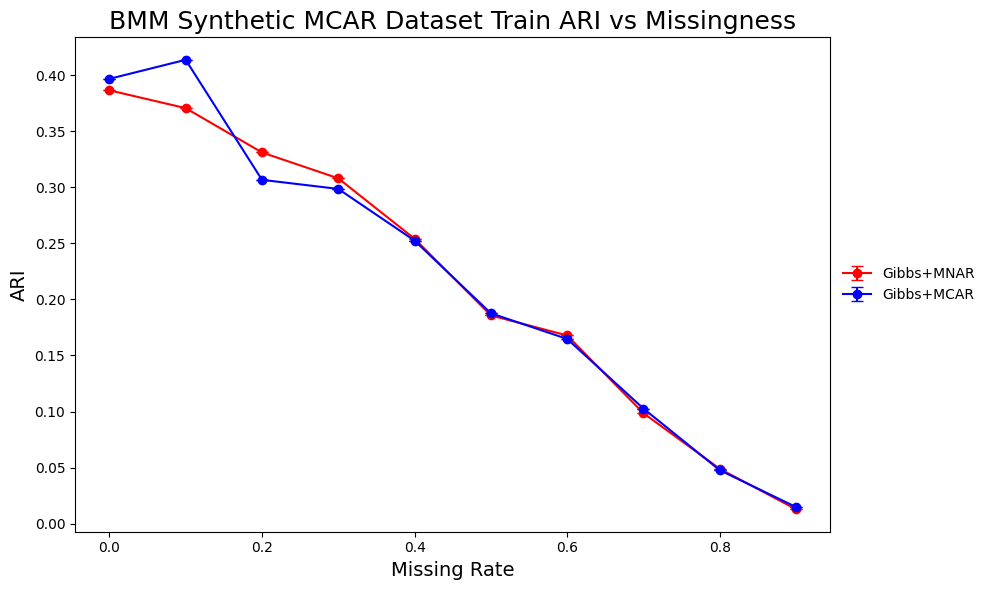

In [828]:
plot_by_missingness_line(bmm_mnar_vs_mcar_df, metric='train_ARI', title="BMM Synthetic MCAR Dataset Train ARI vs Missingness", ylabel="ARI")

In [830]:
gmm_mnar_vs_mcar_df = pd.read_csv("./mnar/gmm_synthetic.csv")

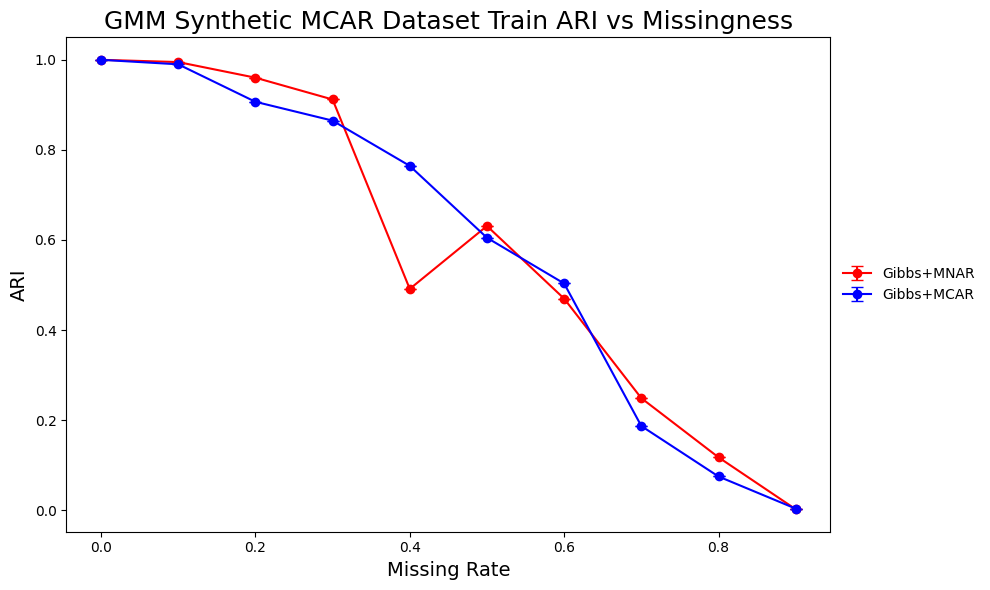

In [833]:
plot_by_missingness_line(gmm_mnar_vs_mcar_df, metric='train_ARI', title="GMM Synthetic MCAR Dataset Train ARI vs Missingness", ylabel="ARI")

---

# Generalization

In [ ]:
def plot_train_vs_test_by_missingness_line(df, method, metrics,title,ylabel):

    # Create figure and axis
    plt.figure(figsize=(10, 6))

    sub_df = df[df['method'] == method].sort_values(by='missing_rate')
    for metric in metrics:
        plt.errorbar(
            sub_df['missing_rate'],
            sub_df[metric] if metric in sub_df.columns else sub_df[metric],
            yerr=sub_df[f'{metric}_std'] if f'{metric}_std' in sub_df.columns else sub_df[f'{metric}_std'],
            label=metric.replace("_", " "),
            capsize=4,
            marker='o',
            linestyle='-',
        )

    plt.xlabel('Missing Rate', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

# Gibbs Train vs Test

## BMM Synthetic 

In [ ]:
bmm_synthetic_df = pd.read_csv("./Results/bmm_synthetic.csv")

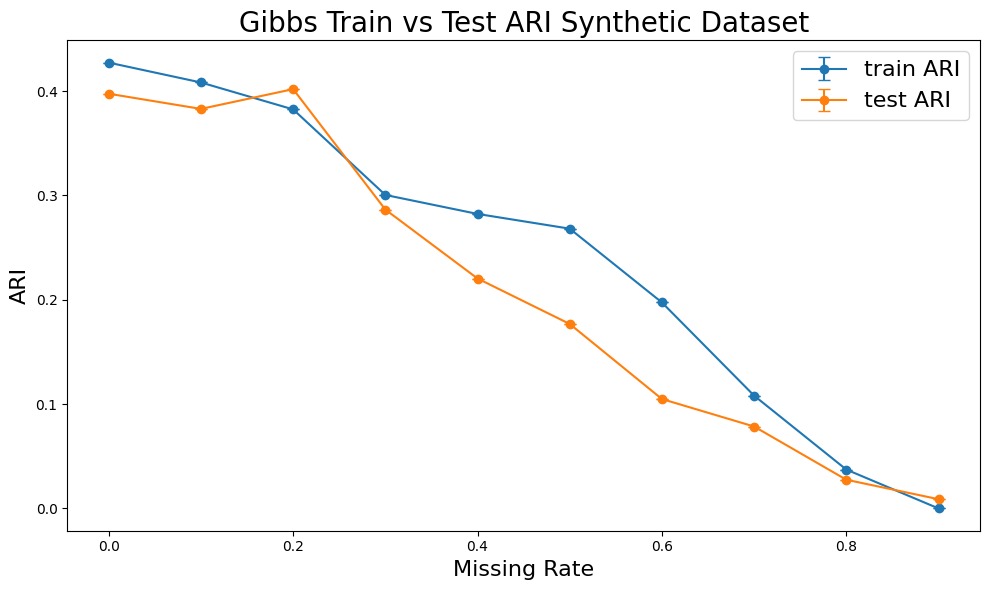

In [ ]:
plot_train_vs_test_by_missingness_line(bmm_synthetic_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI Synthetic Dataset","ARI")

## BMM Shapes

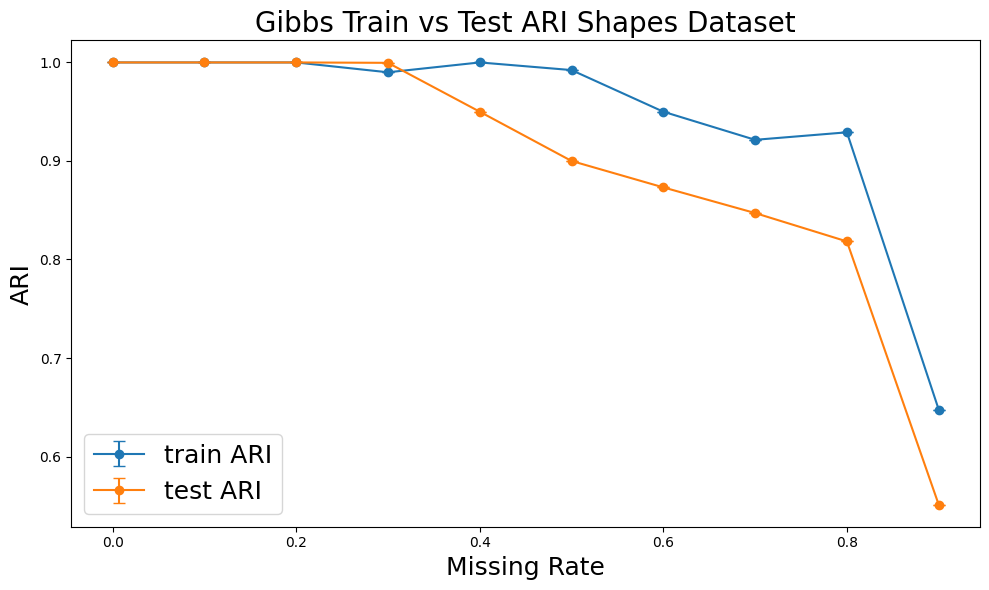

In [ ]:
plot_train_vs_test_by_missingness_line(shapes_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI Shapes Dataset","ARI")

## GMM Synthetic

In [ ]:
synthetic_df_gmm = pd.read_csv("./Results/gmm_synthetic.csv")

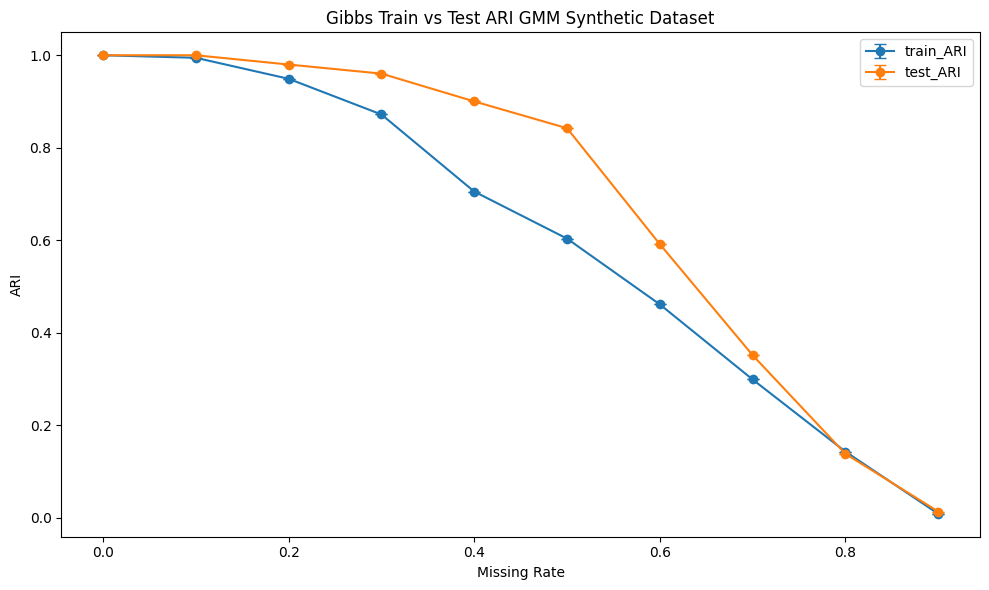

In [ ]:
plot_train_vs_test_by_missingness_line(synthetic_df_gmm, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Synthetic Dataset","ARI")

## GMM Penguins

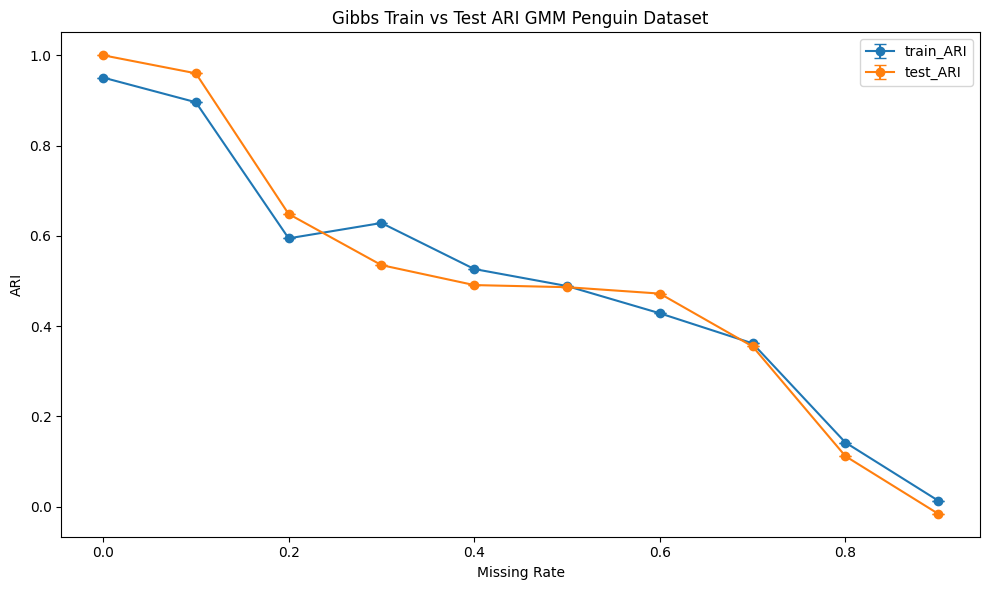

In [ ]:
plot_train_vs_test_by_missingness_line(penguin_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Penguin Dataset","ARI")

## Iris GMM

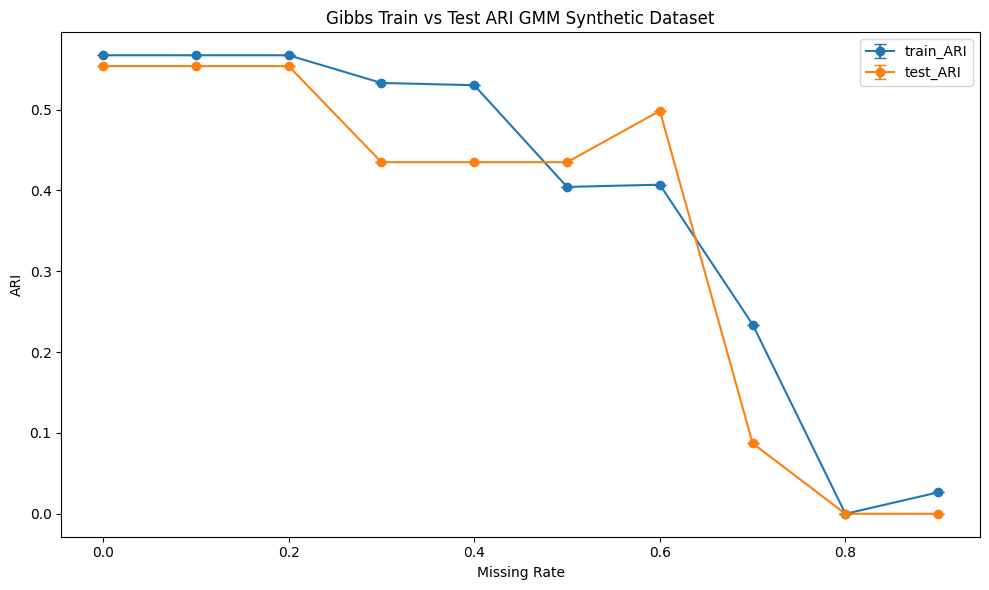

In [ ]:
plot_train_vs_test_by_missingness_line(iris_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Synthetic Dataset","ARI")

## Digits GMM

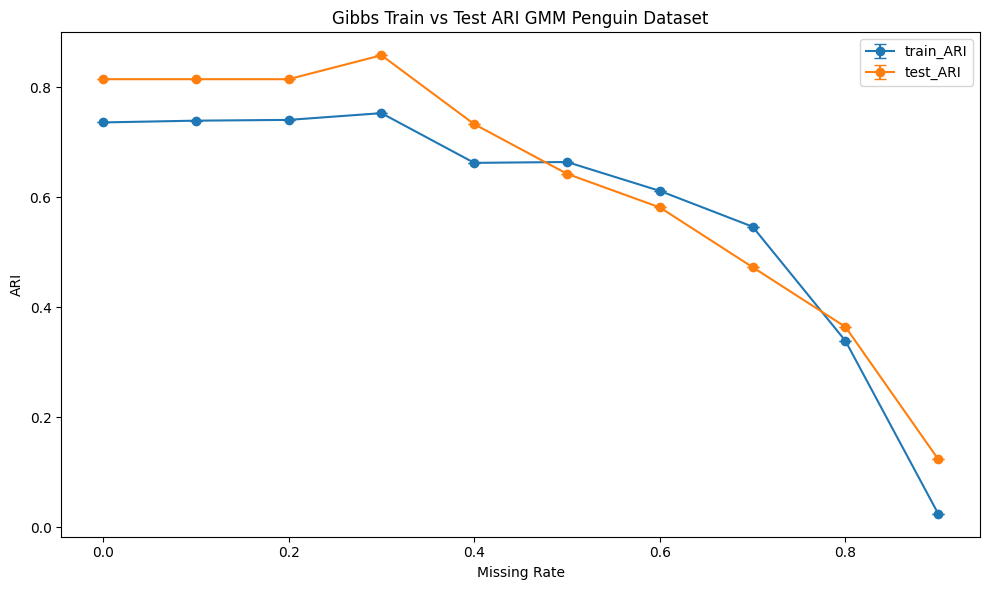

In [ ]:
plot_train_vs_test_by_missingness_line(digits_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Penguin Dataset","ARI")

---

In [51]:
def plot_train_vs_test_by_missingness_line(df, method, metrics,title,ylabel):

    # Create figure and axis
    plt.figure(figsize=(10, 6))

    sub_df = df[df['method'] == method].sort_values(by='missing_rate')
    for metric in metrics:
        plt.errorbar(
            sub_df['missing_rate'],
            sub_df[metric] if metric in sub_df.columns else sub_df[metric],
            yerr=sub_df[f'{metric}_std'] if f'{metric}_std' in sub_df.columns else sub_df[f'{metric}_std'],
            label=metric.replace("_", " "),
            capsize=4,
            marker='o',
            linestyle='-',
        )

    plt.xlabel('Missing Rate', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

# Gibbs Train vs Test

## BMM Synthetic 

In [26]:
bmm_synthetic_df = pd.read_csv("./Results/bmm_synthetic.csv")

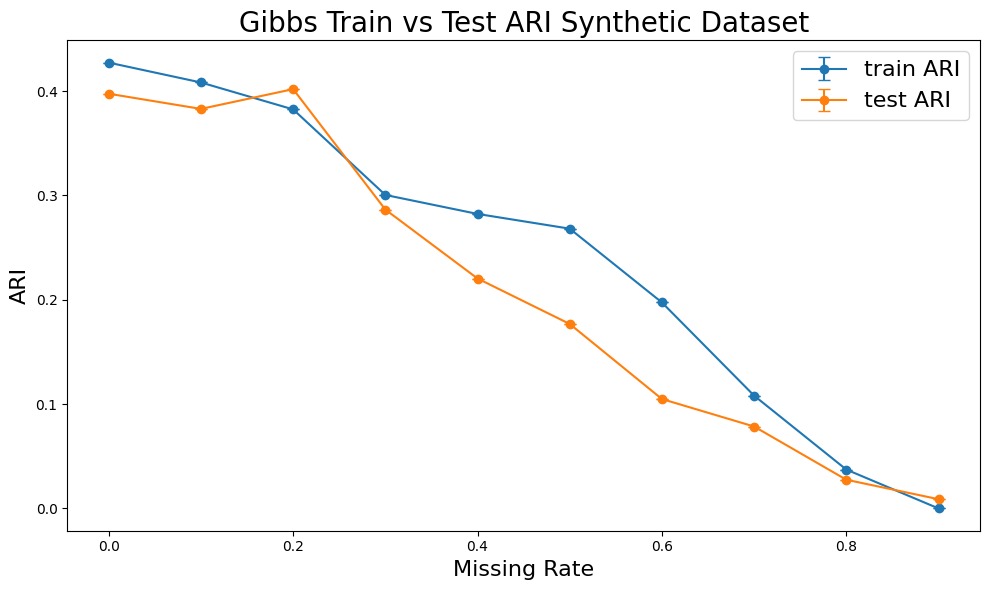

In [49]:
plot_train_vs_test_by_missingness_line(bmm_synthetic_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI Synthetic Dataset","ARI")

## BMM Shapes

In [31]:
shapes_df = pd.read_csv("Results/bmm_shapes.csv")

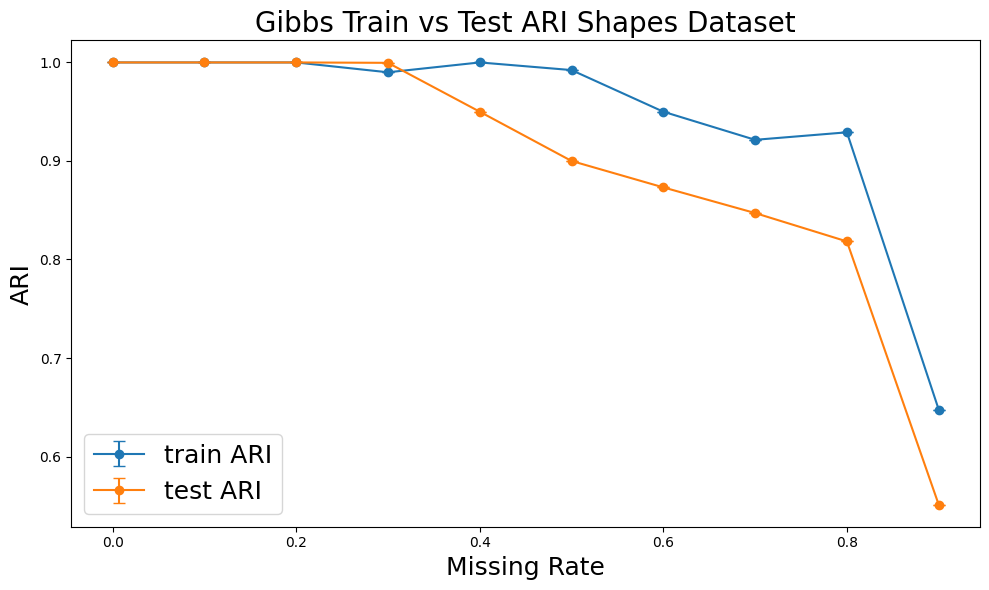

In [52]:
plot_train_vs_test_by_missingness_line(shapes_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI Shapes Dataset","ARI")

## GMM Synthetic

In [33]:
synthetic_df_gmm = pd.read_csv("./Results/gmm_synthetic.csv")

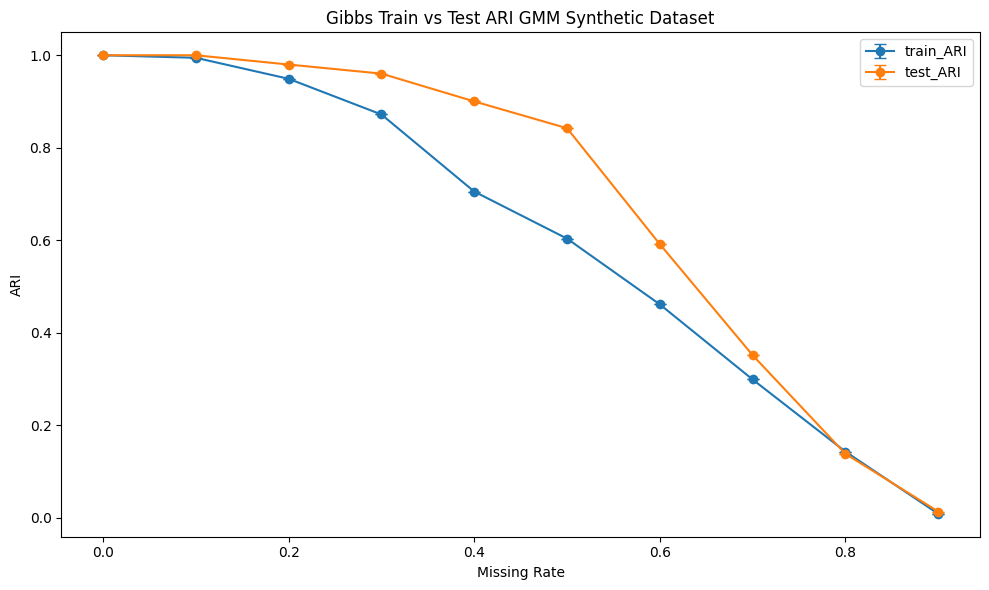

In [34]:
plot_train_vs_test_by_missingness_line(synthetic_df_gmm, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Synthetic Dataset","ARI")

## Iris GMM

In [36]:
iris_df = pd.read_csv('./Results/gmm_iris.csv')

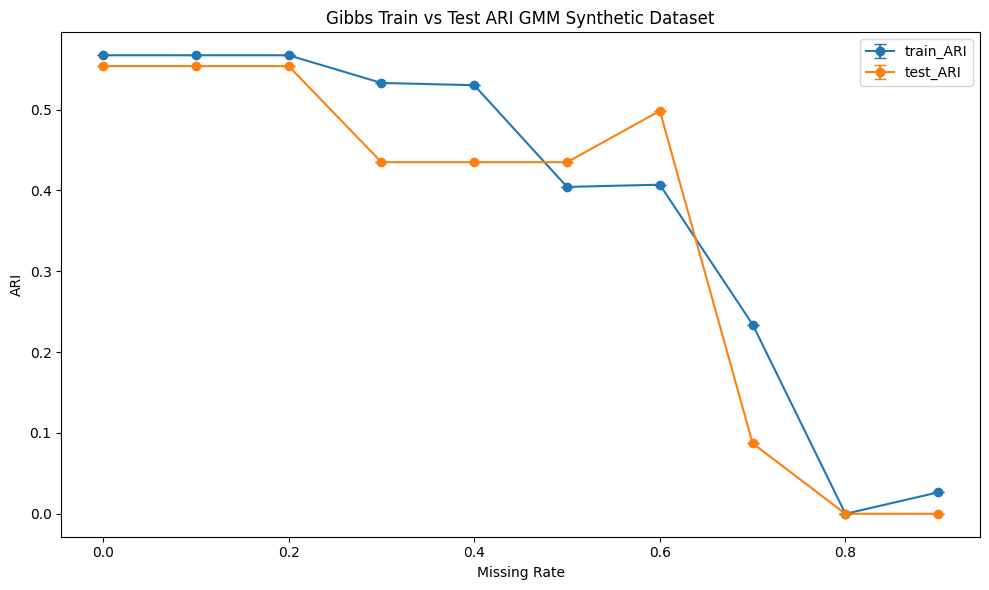

In [37]:
plot_train_vs_test_by_missingness_line(iris_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Synthetic Dataset","ARI")

## Digits GMM

In [38]:
digits_df = pd.read_csv("./Results/gmm_digits5x5.csv")

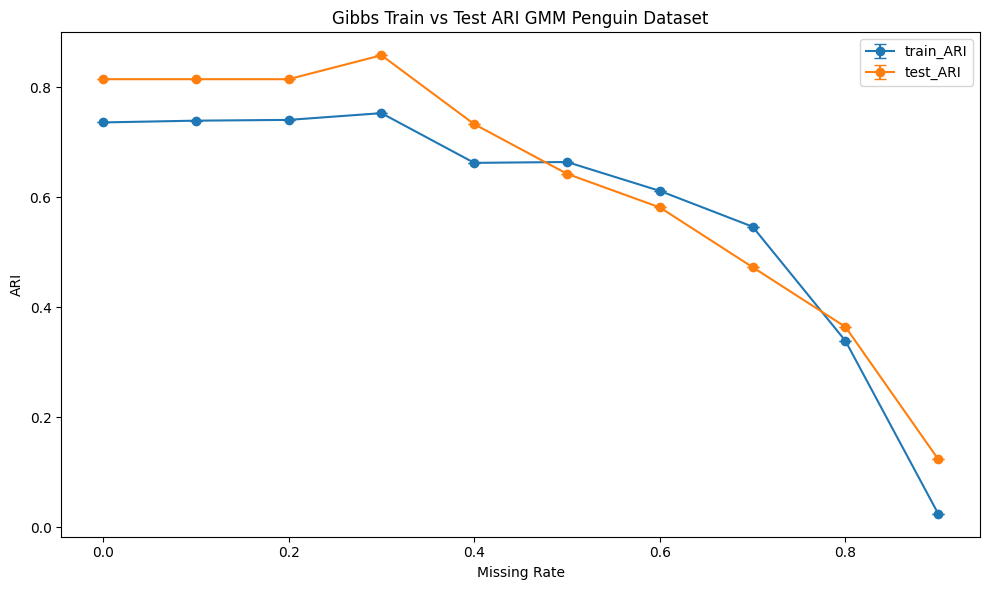

In [39]:
plot_train_vs_test_by_missingness_line(digits_df, 'Gibbs',["train_ARI","test_ARI"],"Gibbs Train vs Test ARI GMM Penguin Dataset","ARI")